In [1]:
import lucem_illud #Special module written for this class

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm #Still for graphics
import matplotlib.colors # For nice colours
import wordcloud
import numpy as np
import scipy
import glob
import seaborn as sns
import sklearn.manifold
import itertools
import json
import ast
import urllib.parse
from bs4 import BeautifulSoup as bs
import spacy #comp-linguistics
import graphviz #displays the graphs
import gensim#For topic modeling

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#To process text data
import re
import time
import string
import statsmodels.formula.api as smf
from gensim import corpora, models
from collections import Counter
from datetime import datetime
from langdetect import detect
from textblob import Word
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

/Users/gaomingtao/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Load Dataset

In [2]:
# Load Dataset
brand = "UnderArmour"
reddit = pd.read_csv("Data/Reddit/{}.csv".format(brand))
twitter = pd.read_csv("Data/Twitter/{}.csv".format(brand))
ins = pd.read_csv("Data/Instagram/{}.csv".format(brand))
youtube = pd.read_csv("Data/YouTube/{}.csv".format(brand))

In [3]:
#Combine the title and body of Reddit posts
reddit['body'].replace(np.nan, "", inplace=True)
reddit['text'] = reddit['title'] + reddit['body']
twitter['text'] = twitter['text'].str.replace('http\S+|www.\S+', '', case=False)
ins.rename(columns={'caption': 'text'}, inplace=True)
youtube['text'] = youtube['title'] + youtube['captions']

In [4]:
#Drop nan and duplicate text
def drop_na_dup(df):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(subset = ["text"], inplace=True)
    
drop_na_dup(reddit)
drop_na_dup(twitter)
drop_na_dup(ins)
drop_na_dup(youtube)

In [5]:
pd.DataFrame({'data': ['Reddit', 'Twitter', 'Instagram', 'YouTube'],
              'shape': [reddit.shape, twitter.shape, ins.shape, youtube.shape,]})

,data,shape
0,Reddit,"(933, 8)"
1,Twitter,"(6467, 9)"
2,Instagram,"(2853, 10)"
3,YouTube,"(523, 13)"


## Counting Words & Phrases

#### Tokenize

In [6]:
def tokenize(df, size=2400):
    df = df[:size]
    df['tokenized_text'] = df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
    df['word_counts'] = df['tokenized_text'].apply(lambda x: len(x))
    return df
    
reddit = tokenize(reddit)
twitter = tokenize(twitter)
ins = tokenize(ins)
youtube = tokenize(youtube)

#### Words Count

In [7]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def wordCounter(df, limit=20):
    tokens = []
    for token in df['tokenized_text']:
        tokens += token

    wordCounts = {}
    for word in df['tokenized_text'].sum():
        wLower = word.lower()
        if word not in stopwords:
            if word in wordCounts:
                wordCounts[word] += 1
            else:
                wordCounts[word] = 1
    
    wordFreq_lst = []
    for word, count in sorted(wordCounts.items(), key = lambda x : x[1], reverse = True)[:limit]:
        wordFreq_lst.append(word)
    
    wordCounts_df = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        wordCounts_df['word'].append(w)
        wordCounts_df['count'].append(c)
    wordCounts_df = pd.DataFrame(wordCounts_df) 
    wordCounts_df.sort_values('count', ascending=False, inplace=True)
    return tokens, wordFreq_lst, wordCounts_df

In [8]:
token_rdt, wordFreq_rdt, wordsCount_rdt = wordCounter(reddit)
token_twt, wordFreq_twt, wordsCount_twt = wordCounter(twitter)
token_ins, wordFreq_ins, wordsCount_ins = wordCounter(ins)
token_ytb, wordFreq_ytb, wordsCount_ytb = wordCounter(youtube)

In [9]:
def normalize(df, words_freq, limit=5):
    df['normalized_tokens'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, extra_stop=words_freq[:limit]))
    return df

reddit = normalize(reddit, wordFreq_rdt)
twitter = normalize(twitter, ['rt'] + wordFreq_twt, 8)
ins = normalize(ins, wordFreq_ins)
youtube = normalize(youtube, wordFreq_ytb, 10)

In [10]:
def detectLanguage(df, col):
    for index, row in df[col].iteritems():
        try:
            lang = detect(row)
            df.loc[index, 'language'] = lang
        except:
            df.loc[index, 'language'] = "not detectable"
    return df

In [11]:
reddit = detectLanguage(reddit,'text')
reddit = reddit[reddit['language'] == 'en']
twitter = detectLanguage(twitter,'text')
twitter = twitter[twitter['language'] == 'en']
ins = detectLanguage(ins,'text')
ins = ins[ins['language'] == 'en']

In [12]:
reddit.head()

,title,upvotes,upvote_ratio,url,num_commns,created,body,text,tokenized_text,word_counts,normalized_tokens,language
0,15.0% Cash Back w/ Rakuten,3,1.00,https://www.reddit.com/r/UnderArmour/comments/...,0,2021-05-10 18:30:26,Stores pay Rakuten a commission for sending yo...,15.0% Cash Back w/ RakutenStores pay Rakuten a...,"[15.0, Cash, Back, w/, RakutenStores, pay, Rak...",54,"[cash, w/, rakutenstores, pay, rakuten, commis...",en
1,Golf shoes,3,1.00,https://www.reddit.com/r/UnderArmour/comments/...,5,2021-05-08 14:54:23,Having a look at these https://www.underarmour...,Golf shoesHaving a look at these https://www.u...,"[Golf, shoesHaving, a, look, at, these, https:...",34,"[golf, shoeshaving, look, https://www.underarm...",en
2,Offer Codes,1,0.60,https://www.reddit.com/r/UnderArmour/comments/...,1,2021-05-06 08:38:23,"Hello my dear UA redditors, I've come to find ...","Offer CodesHello my dear UA redditors, I've co...","[Offer, CodesHello, my, dear, UA, redditors, I...",63,"[offer, codeshello, dear, ua, redditors, ve, c...",en
3,Does this even exist?,1,0.99,https://i.redd.it/nbq6917zz5x61.jpg,6,2021-05-04 16:37:58,,Does this even exist?,"[Does, this, even, exist]",4,[exist],en
4,Under Armour Reports First Quarter 2021 Result...,12,1.00,http://crweworld.com/article/news-provided-by-...,0,2021-05-04 06:59:22,,Under Armour Reports First Quarter 2021 Result...,"[Under, Armour, Reports, First, Quarter, 2021,...",11,"[armour, reports, quarter, results, raises, ye...",en


In [13]:
twitter.head()

,time,text,user_name,user_location,retweet_cnt,favorite_cnt,hashtags,user_mentions,is_retweet,tokenized_text,word_counts,normalized_tokens,language
0,2021-03-09 19:33:27,@Nickguy2014 @UnderArmour I saw them and fell ...,NotUrPixieBitch,rolling in it,0,0,[],"['Nickguy2014', 'UnderArmour']",False,"[@Nickguy2014, @UnderArmour, I, saw, them, and...",22,"[@nickguy2014, @underarmour, saw, fell, love, ...",en
1,2021-03-09 19:28:51,So good I had to share! Check out all the item...,Reggie25309809,NaN,0,0,"['poshmark', 'fashion']","['Poshmarkapp', 'FashionPlaza3']",False,"[So, good, I, had, to, share, Check, out, all,...",20,"[share, check, m, loving, @poshmarkapp, @fashi...",en
2,2021-03-09 19:28:11,RT @ZackSnyder: @UnderArmour @MaranathaSports ...,JG202392020518,"Union City, NJ",4,0,[],"['ZackSnyder', 'UnderArmour', 'maranathasports']",True,"[RT, @ZackSnyder, @UnderArmour, @MaranathaSpor...",5,"[@zacksnyder, @underarmour, @maranathasports, ...",en
3,2021-03-09 19:28:00,So good I had to share! Check out all the item...,NotaroCindy,NaN,0,0,"['poshmark', 'fashion', 'style', 'shopmycloset']",['Poshmarkapp'],False,"[So, good, I, had, to, share, Check, out, all,...",20,"[share, check, m, loving, @poshmarkapp, poshma...",en
4,2021-03-09 19:27:44,@PropBetGuy @KhanLocks @UnderArmour @Nike @adi...,DanRivera228,"Eugene, Oregon",0,0,[],"['PropBetGuy', 'KhanLocks', 'UnderArmour', 'Ni...",False,"[@PropBetGuy, @KhanLocks, @UnderArmour, @Nike,...",21,"[@propbetguy, @khanlocks, @underarmour, @nike,...",en


In [14]:
ins.head()

,text,country,dimensions,full_name,image_url,likes,location,tagged_account,timestamp,user,tokenized_text,word_counts,normalized_tokens,language
1,Flicka da wrist @stephencurry30 @currybrand \n...,NaN,"{'height': 1350, 'width': 1080}",rafaelaam,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,5637,NaN,"['nba', 'stephencurry30', 'warriors', 'bleache...",2021-03-09 04:04:03,spidrawman,"[Flicka, da, wrist, @stephencurry30, @currybra...",7,"[flicka, da, wrist, @stephencurry30, @currybra...",en
2,Shine even if you are surrounded by darkness ✨...,CA,"{'height': 1079, 'width': 1080}",𝕳𝖆𝖗𝖒𝖊𝖊𝖙 𝕶𝖆𝖚𝖗,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,5988,"{'street_address': '', 'zip_code': '', 'city_n...","['fashionnova', 'underarmourwomen', 'madnecia'...",2021-03-09 00:10:15,hsodhi25,"[Shine, even, if, you, are, surrounded, by, da...",38,"[shine, surrounded, darkness, ✨, love, instago...",en
3,So happy to play next tournament with my new p...,NaN,"{'height': 1080, 'width': 1080}",Yumanky Sosa,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,191,NaN,[],2021-03-09 18:05:37,yumanky,"[So, happy, to, play, next, tournament, with, ...",23,"[happy, play, tournament, new, paddle, tyson, ...",en
4,2 PBs in a row 😃 God is so good and so faithfu...,ZA,"{'height': 719, 'width': 1080}",Kyla Jacobs,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,184,"{'street_address': '', 'zip_code': '', 'city_n...","['underarmour', 'uarunning', 'nolene_conrad', ...",2021-03-09 01:58:29,kyla_jac0bs,"[2, PBs, in, a, row, 😃, God, is, so, good, and...",68,"[pbs, row, 😃, god, faithful, plan, purpose, th...",en
5,lets gooo!\n\n-FOLLOW @therockperformance FOR ...,NaN,"{'height': 800, 'width': 750}",Dwayne Johnson | Fanpage,https://instagram.ffxe1-1.fna.fbcdn.net/v/t51....,1403,NaN,[],2021-03-09 08:01:37,therockperformance,"[lets, gooo, -FOLLOW, @therockperformance, FOR...",57,"[lets, gooo, -follow, @therockperformance, -fo...",en


In [15]:
youtube.head()

,captions,categoryId,channelId,channelTitle,commentCount,dislikeCount,favoriteCount,likeCount,tags,title,videoId,viewCount,text,tokenized_text,word_counts,normalized_tokens
2,[Music]hi everyone abby heretoday i'm going to...,25,UClYiny8IhDsIk5SivucNl7g,WJZ,1,1,0,10,['Eyewitness News Evening'],Under Armour Downsizes Port Covington Headquar...,YF9w844e4rI,350,Under Armour Downsizes Port Covington Headquar...,"[Under, Armour, Downsizes, Port, Covington, He...",556,"[armour, downsizes, port, covington, headquart..."
3,unarmor's plans for its new headquartersin bal...,26,UCEaTAQbuyJ_FWOOQ5OsbK5A,Shop Zappos,0,0,0,2,No Tags,Under Armour HOVR Sonic 4 SKU: 9469599,gu9Az0XcQ-Q,526,Under Armour HOVR Sonic 4 SKU: 9469599unarmor'...,"[Under, Armour, HOVR, Sonic, 4, SKU, 9469599un...",90,"[armour, hovr, sonic, sku, 9469599unarmor, pla..."
4,[Music]this sneaker has bluetooth connectivity...,26,UCEaTAQbuyJ_FWOOQ5OsbK5A,Shop Zappos,0,1,0,0,No Tags,Under Armour Kids Charged Bandit 6 (Big Kid) S...,3dDEgSiSvU4,45,Under Armour Kids Charged Bandit 6 (Big Kid) S...,"[Under, Armour, Kids, Charged, Bandit, 6, Big,...",102,"[armour, kids, charged, bandit, big, kid, sku,..."
5,[Music]these sneakers have a textile upper wit...,26,UC9kwUDxTNsBlOXQL7to-2SA,Pretoland,7,Not available,0,Not available,"['preto on tour', 'pretoland', 'Under Armour H...",Under Armour HOVR Summit Fat Tire [sub],LVvxtwqZqxg,979,Under Armour HOVR Summit Fat Tire [sub][Music]...,"[Under, Armour, HOVR, Summit, Fat, Tire, sub][...",82,"[armour, hovr, summit, fat, tire, sub][music]t..."
8,[Music]the ua ignite 6sl from under armour is ...,26,UCEaTAQbuyJ_FWOOQ5OsbK5A,Shop Zappos,1,0,0,1,No Tags,Under Armour Ignite Vi Graphic FB SKU: 9469592,KcwLLceu1hQ,146,Under Armour Ignite Vi Graphic FB SKU: 9469592...,"[Under, Armour, Ignite, Vi, Graphic, FB, SKU, ...",89,"[armour, ignite, vi, graphic, fb, sku, 9469592..."


In [12]:
df_lst = [reddit, twitter, ins, youtube]
title_lst = ["Reddit", "Twitter", "Instagram", "YouTube"]

#### Frequently Used Hashtags

In [17]:
# This function is used to extract hashtags from the caption
def get_hashtags(text, order=False):
    tags = list([item.strip("#.,-\"\'&*^!") for item in text.split() if (item.startswith("#") and len(item) < 256)])
    return sorted(tags) if order else tags

# To display the most frequent hashtags appeared together with the hashtag studied in the captions
def get_most_freq_hashtag(df_list, title_list, n=20):
    for i in range(len(df_list)):
        # Create a list to store all hashtags used in captions
        hashtags = []
        if title_list[i] != "YouTube":
            for row in df_list[i].text:
                hashtags += get_hashtags(row)
        else:
            df_list[i] = df_list[i][df_list[i].tags != 'No Tags']
            for row in df_list[i].tags:
                row = ast.literal_eval(row)
                hashtags += row
        # Count the frequency of each hashtag and display the top 20 most frequent hashtags
        hashtag_freq = Counter(hashtags)
        top_n = hashtag_freq.most_common()[1:n+1]

        # Plot the most frequent hashtags that appeared with hashtag #pumpkinspicelatte
        word, frequency = zip(*top_n)
        indices = np.arange(len(top_n))
        plt.bar(indices, frequency)
        plt.xticks(indices, word, rotation='vertical')
        plt.title("Top {} Most Frequent Hashtags ({})".format(n, title_list[i]))
        plt.xlabel("hashtags")
        plt.ylabel("counts")
        plt.tight_layout()
        plt.show()
        print(top_n)

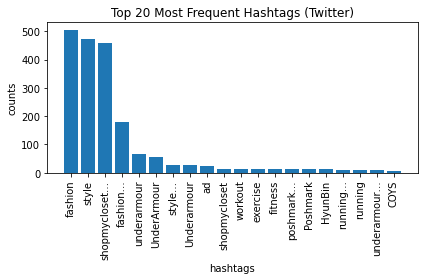

[('fashion', 506), ('style', 473), ('shopmycloset…', 458), ('fashion…', 181), ('underarmour', 65), ('UnderArmour', 55), ('style…', 28), ('Underarmour', 26), ('ad', 25), ('shopmycloset', 14), ('workout', 14), ('exercise', 14), ('fitness', 13), ('poshmark…', 13), ('Poshmark', 12), ('HyunBin', 12), ('running…', 11), ('running', 10), ('underarmour…', 9), ('COYS', 8)]


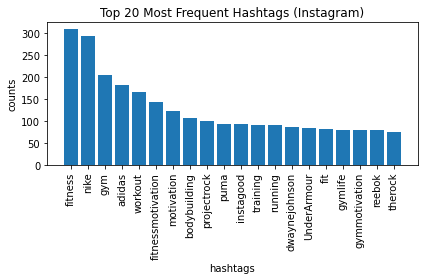

[('fitness', 309), ('nike', 293), ('gym', 205), ('adidas', 182), ('workout', 166), ('fitnessmotivation', 144), ('motivation', 123), ('bodybuilding', 106), ('projectrock', 101), ('puma', 94), ('instagood', 93), ('training', 92), ('running', 90), ('dwaynejohnson', 86), ('UnderArmour', 85), ('fit', 82), ('gymlife', 80), ('gymmotivation', 79), ('reebok', 79), ('therock', 76)]


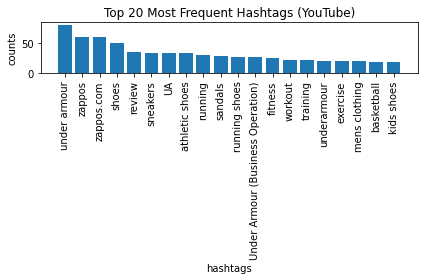

[('under armour', 81), ('zappos', 61), ('zappos.com', 61), ('shoes', 51), ('review', 35), ('sneakers', 34), ('UA', 34), ('athletic shoes', 34), ('running', 31), ('sandals', 29), ('running shoes', 27), ('Under Armour (Business Operation)', 27), ('fitness', 26), ('workout', 23), ('training', 22), ('underarmour', 21), ('exercise', 21), ('mens clothing', 20), ('basketball', 19), ('kids shoes', 19)]


In [18]:
get_most_freq_hashtag(df_lst[1:], title_lst[1:])

#### Sensitive Scores

In [13]:
# Function used to process captions by lemmatization and removing punctuations and most/least frequent words
# return the processed captions as pandas series
def processTextCalculateSentiment(df):
    # Remove all hashtags, punctuations, and stopwords
    captions = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    captions = captions.apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x) for x in x.split()))
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in nltk.corpus.stopwords.words('english')))
    
    # Remove most 10 common words
    freq = pd.Series(' '.join(captions).split()).value_counts()[:10]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))
    # Remove 10 least frequent words
    least_freq = pd.Series(' '.join(captions).split()).value_counts()[-10:]
    captions = captions.apply(lambda x: " ".join(x for x in x.split() if x not in list(freq.index)))

    # Lemmatization
    captions = captions.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    captions.replace('', np.nan, inplace=True)
    captions.dropna(inplace=True)
    
    df['fully_proccessed_tokens'] = captions
    df['sentiment_score'] = df['fully_proccessed_tokens'].apply(lambda x: sentiment_score(str(x)))
    return df

# Function used to compute sentimental score from the input
def sentiment_score(text):
    sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

In [14]:
def plotSentimentDistribution(df_list, title_list):
    for i in range(len(df_list)):
        df_list[i] = processTextCalculateSentiment(df_list[i])
        df_list[i]['sentiment_score'].hist()
        plt.xlabel('sentiment score')
        plt.ylabel('counts')
        plt.title('Sentiment Scores for ' + title_list[i])
        print('Average Sentiment Score for ' + title_list[i] + ' is ' + 
              str(df_list[i]['sentiment_score'].sum()/df_list[i].shape[0]))
        plt.show()

Average Sentiment Score for Reddit is 0.25011614699331847


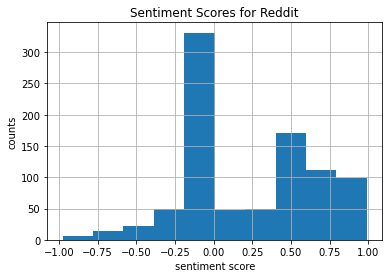

Average Sentiment Score for Twitter is 0.14995737983836666


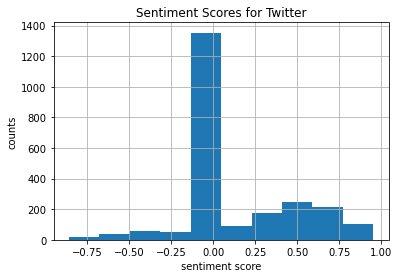

Average Sentiment Score for Instagram is 0.24143665730337077


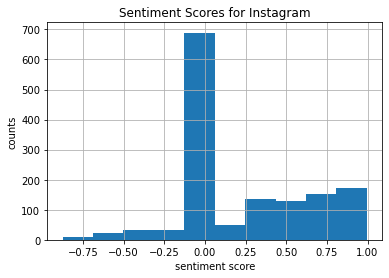

Average Sentiment Score for YouTube is 0.843221223709369


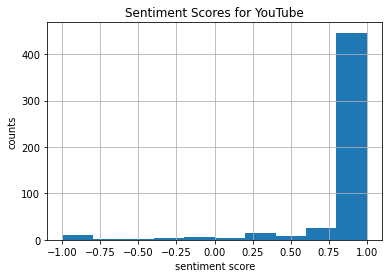

In [15]:
plotSentimentDistribution(df_lst, title_lst)

#### Word Frequency Distribution

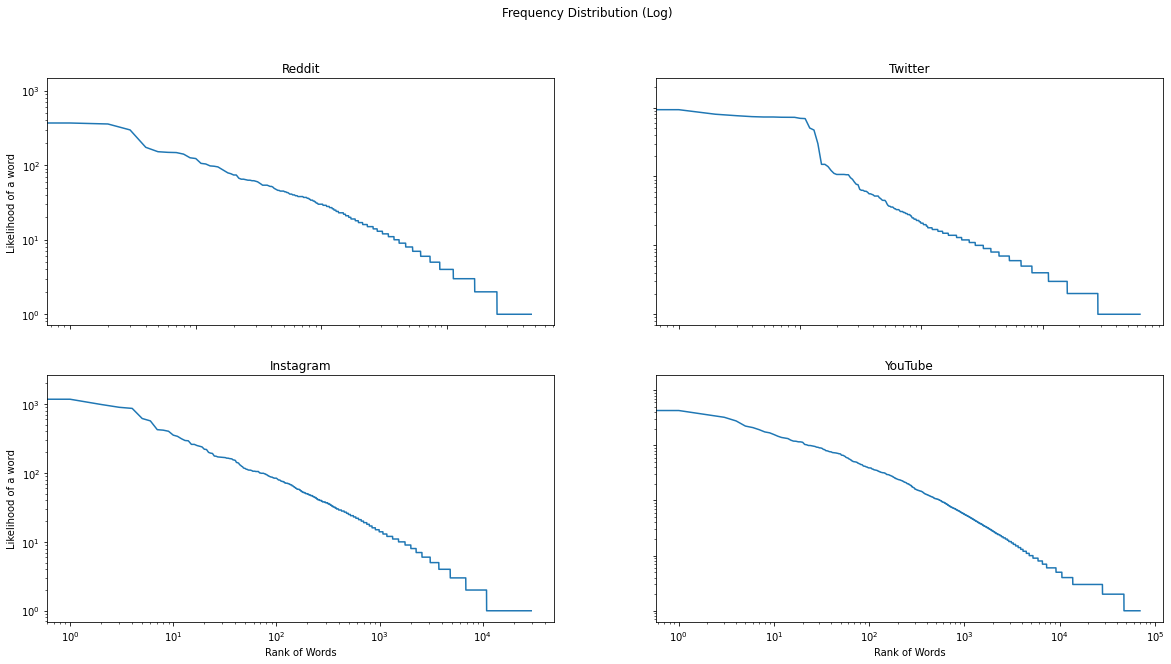

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Frequency Distribution (Log)")

axs[0, 0].plot(range(len(wordsCount_rdt)), wordsCount_rdt['count'])
axs[0, 0].set_title("Reddit")
axs[0, 1].plot(range(len(wordsCount_twt)), wordsCount_twt['count'])
axs[0, 1].set_title("Twitter")

axs[1, 0].plot(range(len(wordsCount_ins)), wordsCount_ins['count'])
axs[1, 0].set_title("Instagram")
axs[1, 1].plot(range(len(wordsCount_ytb)), wordsCount_ytb['count'])
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set(xlabel='Rank of Words', ylabel='Likelihood of a word')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# set the spacing between subplots 
plt.show()

### Word Concordance

In [16]:
text = nltk.Text(token_twt) #Convert t_data into a Text class of nltk
CIndex = nltk.text.ConcordanceIndex(text) #Load the text into a ConcordanceIndex

In [17]:
# The surrounding words of 'enjoy'
CIndex.print_concordance('best')

Displaying 17 of 17 matches:
PRINGKI yo btw @UnderArmour makes the best masks do n't me @Richard_Strange @Che
N @UnderArmour ‘s @UnderArmour is the best brand for apparel Definitively @Nike 
 apparel Definitively @Nike still the best shoes though The @byDVNLLN @UnderArmo
nderArmour @earnestMgraham @ZairaLily best javelin program in the nation @EcsFie
n it was feels like 9F but it was the best I ’ve felt on a run in awhile Celebra
ld Here ’s our in crowd Move with our best sellers Available in store amp online
ycloset @TheRock got project 3s today best shoe Iv ever worn Thank you 🙌 UnderAr
derArmour I 've got them on right now best shoes in the market for sure BloodSwe
our family Always motivated to be the best in my craft and s ad The Under Armour
ail so you can cut down that personal best time Learn more about this elite new 
h no followers get sponsored Personal best run today 8:52 mil RT @Flakes1979 You
 so far from @UnderArmour What ’s the best one 7 Flavors of the Curry 8 so far f

In [18]:
text.common_contexts(['fit'])

keep_under worst_possible strong_body fun_adventure n’t_my
loose_underarmour the_is keep_range improved_and


In [19]:
text.count('like')

59

In [20]:
# Make a plot to show each time a set of words occurs
list_of_words = ['love', 'hate', 'like', 'fit', 'worst', 'best', 'good']
token_lst = [token_rdt, token_twt, token_ins, token_ytb]
def plotWordsOccurance(token_list, title_list, df_list):
    for i in range(len(token_list)):
        text = nltk.Text(token_list[i])
        sns.reset_orig()
        nltk.draw.dispersion.dispersion_plot(text, list_of_words, 
                                             title="Word Occurances in {}".format(title_list[i]))
        sns.set()
                
        num_strong_pos = text.count('love') + text.count('best')
        num_strong_neg = text.count('hate') + text.count('worst')
        num_weak_pos = text.count('like') + text.count('good')
        total_words_count = df_list[i]['word_counts'].sum()
        print('Frequency Strong Positive Words: ' + str(num_strong_pos/total_words_count))
        print('Frequency Strong Negative Words: ' + str(num_strong_neg/total_words_count))
        print('Frequency Weak Positive Words: ' + str(num_weak_pos/total_words_count))
        print('Frequency Emotion Words: ' + str((num_weak_pos+num_strong_pos+num_strong_neg)/total_words_count))

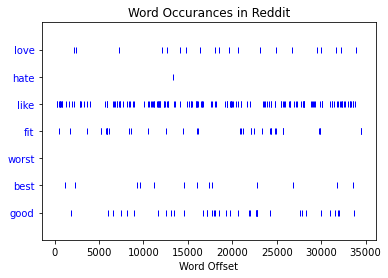

Frequency Strong Positive Words: 0.000962800875273523
Frequency Strong Negative Words: 2.9175784099197667e-05
Frequency Weak Positive Words: 0.005455871626549963
Frequency Emotion Words: 0.006447848285922684


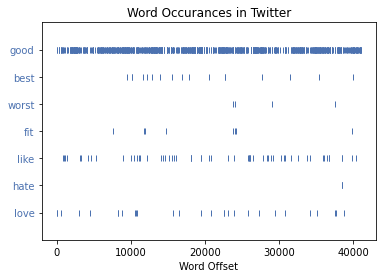

Frequency Strong Positive Words: 0.001103888139335214
Frequency Strong Negative Words: 0.00017171593278547773
Frequency Weak Positive Words: 0.02013982583098246
Frequency Emotion Words: 0.02141542990310315


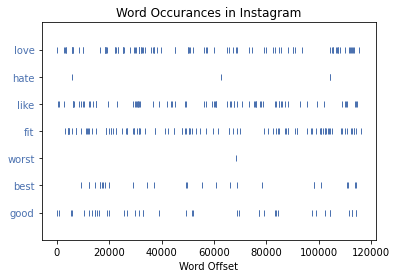

Frequency Strong Positive Words: 0.0017363851617995265
Frequency Strong Negative Words: 7.175145296692258e-05
Frequency Weak Positive Words: 0.001693334290019373
Frequency Emotion Words: 0.003501470904785822


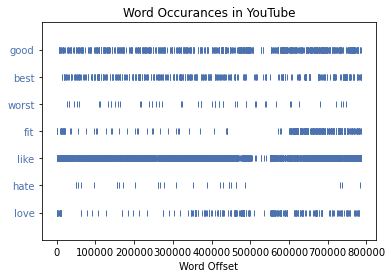

Frequency Strong Positive Words: 0.0008095118275142523
Frequency Strong Negative Words: 0.00010293635483305249
Frequency Weak Positive Words: 0.0051036098890066516
Frequency Emotion Words: 0.006016058071353956


In [21]:
plotWordsOccurance(token_lst, title_lst, df_lst)

#### Word Distribution

#### (1) word frequency distribution (word lengths)

In [29]:
def wordDistributionLength(df_list, title_list, word_length, num_words=20):
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcfdist[word_length].plot(num_words, title=title_list[i])

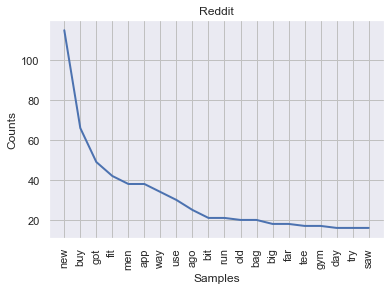

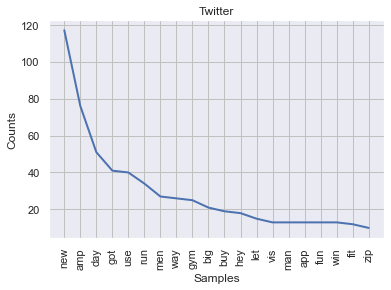

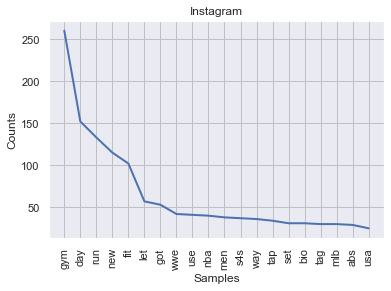

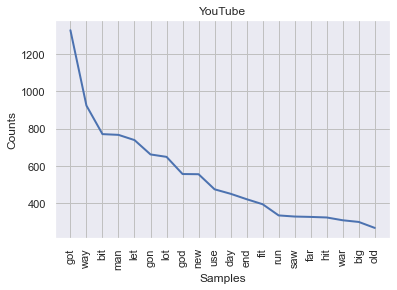

In [30]:
wordDistributionLength(df_lst, title_lst, 3)

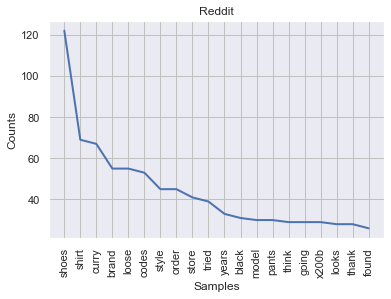

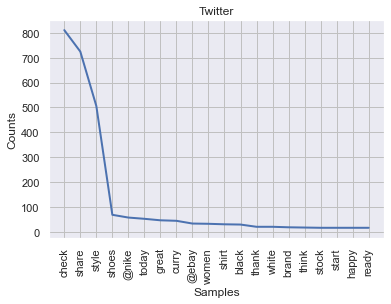

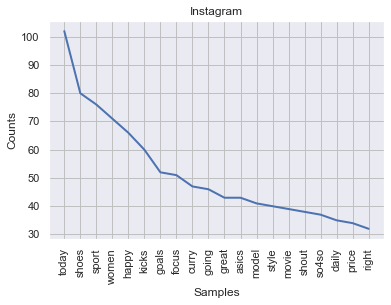

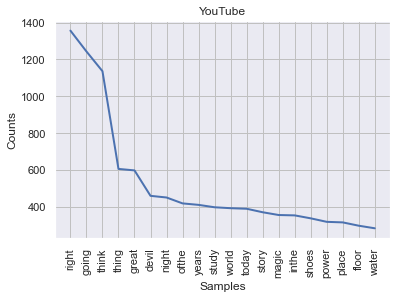

In [31]:
wordDistributionLength(df_lst, title_lst, 5)

#### (2) word frequency distribution (POS)

In [32]:
def wordDistributionPOS(df_list, title_list, pos, num_words=20):
    freqDict = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        POStoWord[pos].plot(num_words, title=title_list[i])
        freqDict[title_list[i]] = POStoWord[pos].most_common(10)
    return pd.DataFrame(freqDict)

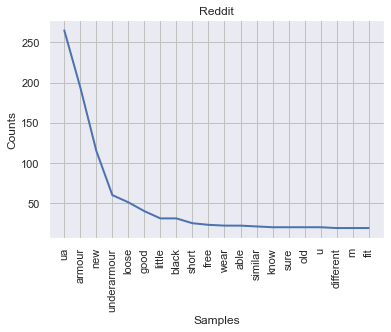

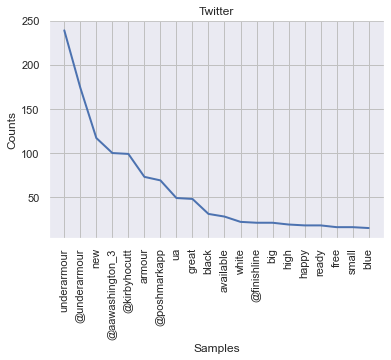

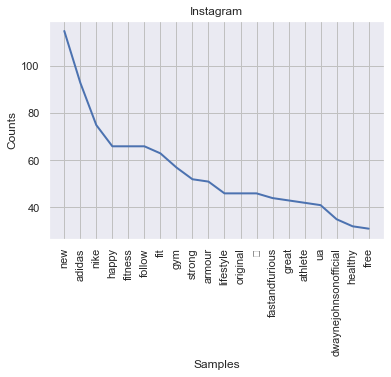

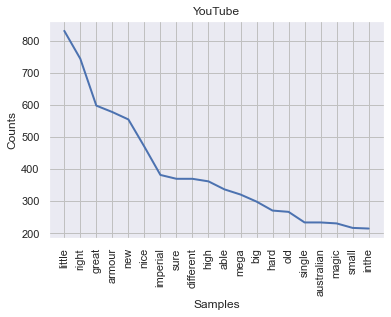

,Reddit,Twitter,Instagram,YouTube
0,"(ua, 265)","(underarmour, 239)","(new, 115)","(little, 831)"
1,"(armour, 194)","(@underarmour, 174)","(adidas, 93)","(right, 744)"
2,"(new, 115)","(new, 117)","(nike, 75)","(great, 598)"
3,"(underarmour, 60)","(@aawashington_3, 100)","(happy, 66)","(armour, 578)"
4,"(loose, 51)","(@kirbyhocutt, 99)","(fitness, 66)","(new, 555)"
5,"(good, 40)","(armour, 73)","(follow, 66)","(nice, 470)"
6,"(little, 31)","(@poshmarkapp, 69)","(fit, 63)","(imperial, 382)"
7,"(black, 31)","(ua, 49)","(gym, 57)","(sure, 370)"
8,"(short, 25)","(great, 48)","(strong, 52)","(different, 370)"
9,"(free, 23)","(black, 31)","(armour, 51)","(high, 362)"


In [33]:
wordDistributionPOS(df_lst, title_lst, 'JJ')

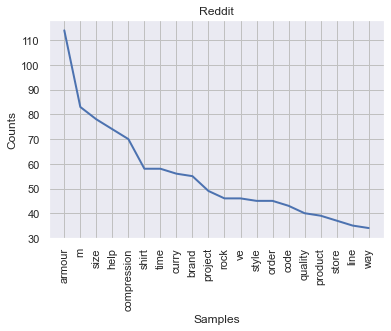

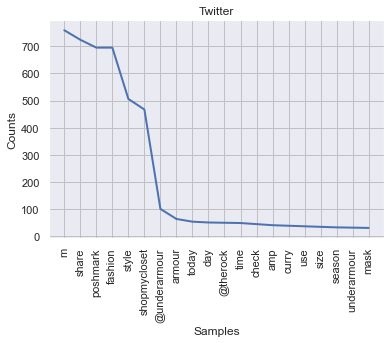

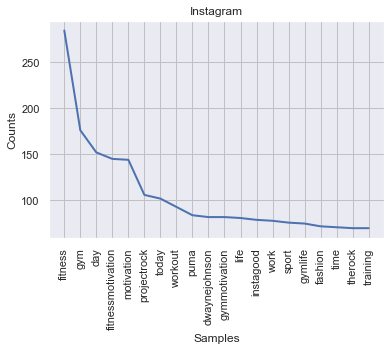

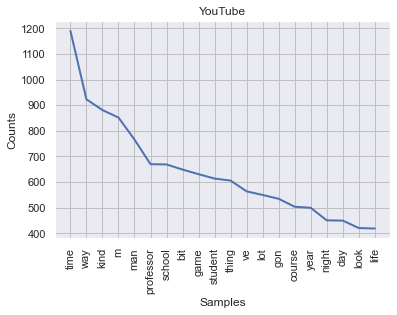

,Reddit,Twitter,Instagram,YouTube
0,"(armour, 114)","(m, 759)","(fitness, 284)","(time, 1190)"
1,"(m, 83)","(share, 724)","(gym, 176)","(way, 923)"
2,"(size, 78)","(poshmark, 695)","(day, 152)","(kind, 881)"
3,"(help, 74)","(fashion, 695)","(fitnessmotivation, 145)","(m, 852)"
4,"(compression, 70)","(style, 506)","(motivation, 144)","(man, 766)"
5,"(shirt, 58)","(shopmycloset, 467)","(projectrock, 106)","(professor, 670)"
6,"(time, 58)","(@underarmour, 101)","(today, 102)","(school, 669)"
7,"(curry, 56)","(armour, 64)","(workout, 93)","(bit, 649)"
8,"(brand, 55)","(today, 54)","(puma, 84)","(game, 631)"
9,"(project, 49)","(day, 51)","(dwaynejohnson, 82)","(student, 614)"


In [34]:
wordDistributionPOS(df_lst, title_lst, 'NN')

#### (3) conditional probability distribution (word length)

In [35]:
def wordProbDistribLength(df_list, title_list, word_length):
    most_common = {}
    for i in range(len(df_list)):
        whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in df_list[i]['normalized_tokens'].sum()))
        whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)
        most_common_word = whcpdist[word_length].max()
        most_common[title_list[i]] = [most_common_word, whcpdist[word_length].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [36]:
wordProbDistribLength(df_lst, title_lst, 5)

,Reddit,Twitter,Instagram,YouTube
0,shoes,check,today,right
1,0.0432633,0.187637,0.0195275,0.0239719


In [37]:
wordProbDistribLength(df_lst, title_lst, 6)

,Reddit,Twitter,Instagram,YouTube
0,armour,loving,follow,armour
1,0.145776,0.26846,0.0385394,0.0208665


#### (4) conditional probability distribution (POS)

In [38]:
def wordProbDistribPOS(df_list, title_list, pos):
    most_common = {}
    for i in range(len(df_list)):
        df_list[i]['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in df_list[i]['normalized_tokens']]
        POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in df_list[i]['normalized_tokens_POS'].sum())
        whcpdist_POStoWord = nltk.ConditionalProbDist(POStoWord, nltk.ELEProbDist)
        most_common_word = whcpdist_POStoWord[pos].max()
        most_common[title_list[i]] = [most_common_word, whcpdist_POStoWord[pos].prob(most_common_word)]
    return pd.DataFrame(most_common)

In [39]:
wordProbDistribPOS(df_lst, title_lst, 'JJ')

,Reddit,Twitter,Instagram,YouTube
0,ua,underarmour,new,little
1,0.0712943,0.0641489,0.0126819,0.00932588


In [40]:
wordProbDistribPOS(df_lst, title_lst, 'NN')

,Reddit,Twitter,Instagram,YouTube
0,armour,m,fitness,time
1,0.0170768,0.0711142,0.0119008,0.00772703


#### (5) Word Cloud

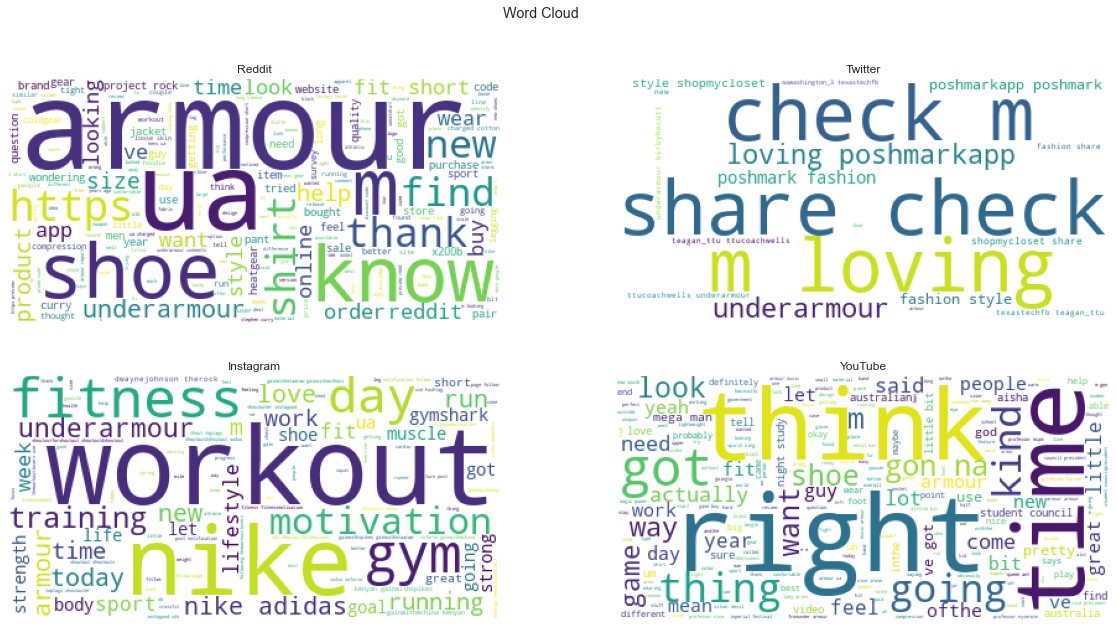

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Word Cloud")

wc_1 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(reddit['normalized_tokens'].sum()))
axs[0, 0].imshow(wc_1)
axs[0, 0].set_title("Reddit")
wc_2 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(twitter['normalized_tokens'].sum()))
axs[0, 1].imshow(wc_2)
axs[0, 1].set_title("Twitter")

wc_3 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(ins['normalized_tokens'].sum()))
axs[1, 0].imshow(wc_3)
axs[1, 0].set_title("Instagram")
wc_4 = wordcloud.WordCloud(background_color="white", max_words=500, mode='RGBA').generate(' '.join(youtube['normalized_tokens'].sum()))
axs[1, 1].imshow(wc_4)
axs[1, 1].set_title("YouTube")

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

#### Bigrams

In [42]:
def bigrams(df_list, title_list):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_dict = {}
    for i in range(len(df_list)):
        bigrams = nltk.collocations.BigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        bigram_dict[title_list[i]] = bigrams.score_ngrams(bigram_measures.student_t)[:10]
    return pd.DataFrame(bigram_dict)

In [43]:
bigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((project, rock), 6.458390568997141)","((loving, @poshmarkapp), 26.00959539471857)","((🆙, 🆙), 16.629993415346185)","((gon, na), 25.66468740331197)"
1,"((r, underarmour), 4.66818133786456)","((m, loving), 25.94066333278283)","((👥, 👥), 13.508075499739077)","((mega, man), 16.45100909229049)"
2,"((loose, skin), 4.551586253398931)","((share, check), 25.925322823343496)","((⚡, ⚡), 13.385494561188544)","((ve, got), 16.345542958203616)"
3,"((charged, cotton), 4.4596875382723935)","((check, m), 25.828827497858047)","((❎, ❎), 12.567074469524956)","((student, council), 16.14549868374813)"
4,"((underarmour, comments), 4.448816296515169)","((poshmark, fashion), 25.316500804327458)","((💨, 💨), 10.734269105028035)","((night, study), 15.3637703501841)"
5,"((years, ago), 4.346979554382464)","((fashion, style), 21.68906034107971)","((🏀, 🏀), 9.872250030216708)","((little, bit), 14.371729333939756)"
6,"(($, $), 4.129526552903414)","((style, shopmycloset), 21.19288892428844)","((nike, adidas), 9.416132726312169)","((professor, nyserwin), 12.679921626583372)"
7,"((heat, gear), 3.9874362365388247)","((@poshmarkapp, poshmark), 20.627757063680992)","((=, =), 8.577173919009972)","((silver, devil), 12.461175946650407)"
8,"((long, sleeve), 3.8536659911460385)","((shopmycloset, share), 16.204698366318823)","((⠀, ⠀), 7.7231951237336816)","((m, going), 11.654470673865033)"
9,"((ua, charged), 3.837804647647837)","((@teagan_ttu, @ttucoachwells), 10.29519277349...","((💭, 💭), 7.060335893878792)","((armour, ua), 11.427211951750904)"


#### Trigrams

In [44]:
def trigrams(df_list, title_list):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    trigram_dict = {}
    for i in range(len(df_list)):
        trigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_list[i]['normalized_tokens'].sum())
        trigram_dict[title_list[i]] = trigrams.score_ngrams(trigram_measures.student_t)[:10]
    return pd.DataFrame(trigram_dict)

In [45]:
trigrams(df_lst, title_lst)

,Reddit,Twitter,Instagram,YouTube
0,"((r, underarmour, comments), 4.472100708963707)","((m, loving, @poshmarkapp), 26.840336770288914)","((🆙, 🆙, 🆙), 16.431052986815963)","((m, gon, na), 10.246525145005426)"
1,"((armour, reports, quarter), 2.9999335376200804)","((check, m, loving), 26.836806385381745)","((👥, 👥, 👥), 13.266270256984873)","((e, e, e), 8.485278499698731)"
2,"((charged, cotton, shirts), 2.9999181944530093)","((share, check, m), 26.836760394649094)","((⚡, ⚡, ⚡), 13.038100869973123)","((professor, nice, irwin), 7.549792596574078)"
3,"((black, friday, cyber), 2.828423299555632)","((poshmark, fashion, style), 22.361174168221186)","((❎, ❎, ❎), 12.489854421298451)","((armour[music, armour, ua), 6.082741364671721)"
4,"((en, mens, ua), 2.645691356639577)","((fashion, style, shopmycloset), 21.6645459702...","((💨, 💨, 💨), 9.899384521230525)","((r, r, r), 5.9999996448785575)"
5,"((armour, brand, house), 2.6450276037725575)","((@poshmarkapp, poshmark, fashion), 21.6471976...","((🏀, 🏀, 🏀), 9.539325704299001)","((armour, armour, ua), 5.830579462804551)"
6,"((d/1kx, cwngdca0rakgzufdqzo5aljgcjxbs7r2ityti...","((loving, @poshmarkapp, poshmark), 21.64589689...","((=, =, =), 7.745908018994827)","((student, council, president), 5.744485319282..."
7,"((document, d/1kx, cwngdca0rakgzufdqzo5aljgcjx...","((style, shopmycloset, share), 17.068265687768...","((gainwithmchina, kenyan, gainwithspikes), 6.5...","((new, south, wales), 5.477218247198543)"
8,"((women, uptown, jogger), 2.449488868460311)","((shopmycloset, share, check), 17.05640499987993)","((kenyan, gainwithspikes, gainwithmtaaraw), 6....","((dot, dot, plus), 4.795829156562196)"
9,"((cwngdca0rakgzufdqzo5aljgcjxbs7r2itytiqxc, ed...","((poshmark, fashion, share), 11.117735459897563)","((gainwithspikes, gainwithmtaaraw, gainwithmut...","((mega, man, game), 4.690171194243836)"


#### KL Divergence

In [46]:
rdt_words = set(reddit['normalized_tokens'].sum())
twt_words = set(twitter['normalized_tokens'].sum())
ins_words = set(ins['normalized_tokens'].sum())
ytb_words = set(youtube['normalized_tokens'].sum())

overlapWords = rdt_words & twt_words & ins_words & ytb_words
overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}

In [47]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

rdtProbArray = makeProbsArray(reddit['normalized_tokens'], overlapWordsDict)
twtProbArray = makeProbsArray(twitter['normalized_tokens'], overlapWordsDict)
insProbArray = makeProbsArray(ins['normalized_tokens'], overlapWordsDict)
ytbProbArray = makeProbsArray(youtube['normalized_tokens'], overlapWordsDict)

In [48]:
# Calculate divergences
rdt_twt_divergence = scipy.stats.entropy(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_divergence))
rdt_ins_divergence = scipy.stats.entropy(rdtProbArray, insProbArray)
print("Reddit & Instagra: {}".format(rdt_ins_divergence))
rdt_ytb_divergence = scipy.stats.entropy(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}".format(rdt_ytb_divergence))

twt_ins_divergence = scipy.stats.entropy(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_divergence))
twt_ytb_divergence = scipy.stats.entropy(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_divergence))
ins_ytb_divergence = scipy.stats.entropy(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}".format(ins_ytb_divergence))

Reddit & Twitter: 0.8369682865002351
Reddit & Instagra: 0.8785429208521682
Reddit & YouTube: 0.8710343906489135
Twitter & Instagram: 1.3945048225535612
Twitter & YouTube: 1.8667024316781244
Instagram & YouTube: 1.1968972054759472


In [49]:
from IPython.display import display

# Elementwise calculation and see which words best distinguish the two corpora
def wordMostDistinguish(probArray_list, title_list, num_words=10):
    kl_df = pd.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
    kl_df = kl_df.sort_index()
    for i in range(len(probArray_list)):
        print(title_list[i])
        result = {}
        for j in range(len(probArray_list)):
            if (probArray_list[j] != probArray_list[i]).all():
                divergence_ew = scipy.special.kl_div(probArray_list[j], probArray_list[i])
                wd_df = kl_df
                wd_df['elementwise divergence'] = divergence_ew
                wd_df = wd_df.sort_values(by='elementwise divergence', ascending=False)[:num_words]
                wd_df[" vs. " + title_list[j]] = wd_df['word'] + ", " + wd_df['elementwise divergence'].astype(str)
                wd_df.drop(columns=['word', 'elementwise divergence'], inplace=True)
                wd_df.reset_index(drop=True, inplace=True)
                result.update(wd_df.to_dict())
        display(pd.DataFrame.from_dict(result))

In [50]:
probArray_lst = [rdtProbArray, twtProbArray, insProbArray, ytbProbArray]
wordMostDistinguish(probArray_lst, title_lst)

Reddit


,vs. Twitter,vs. Instagram,vs. YouTube
0,"loving, 0.35673341741284686","fitness, 0.07149087880778263","ua, 0.023014794220048415"
1,"share, 0.2659517123976852","follow, 0.06935508974774829","school, 0.021346464751422965"
2,"check, 0.26295256453544624","nike, 0.048675613098212715","god, 0.016727623835354515"
3,"style, 0.07627051130675104","motivation, 0.043858875908931255","na, 0.016525568223389523"
4,"m, 0.06748210980313339","gym, 0.03289419381256656","gon, 0.016525568223389523"
5,"ua, 0.01603384602122411","workout, 0.03070601287238106","armour, 0.015158654530368961"
6,"find, 0.00970974268303685","adidas, 0.024016308422094425","course, 0.01467698799467884"
7,"armour, 0.009144273052372559","reebok, 0.02207949327389698","right, 0.01402687279564802"
8,"camp, 0.0053435453650414215","armour, 0.01994417059297797","man, 0.011152341754444987"
9,"compression, 0.005142958478150404","ua, 0.019413959433371493","yeah, 0.010963666366865068"


Twitter


,vs. Reddit,vs. Instagram,vs. YouTube
0,"check, 0.0756102574741777","check, 0.07441379458501338","check, 0.07360808546896422"
1,"loving, 0.07182816139625539","loving, 0.07117351044800724","loving, 0.07298779671150998"
2,"share, 0.06927748503538966","share, 0.06650750828305199","share, 0.0701560848692003"
3,"m, 0.03920678578027972","m, 0.051761768591944986","style, 0.046047934477084385"
4,"style, 0.03541702781429823","nike, 0.05160943533163278","m, 0.04075938295493312"
5,"ua, 0.0280294346630404","fitness, 0.04637602492644275","right, 0.01943802154424086"
6,"find, 0.02320544831823863","style, 0.03908752071009343","said, 0.01807985326380267"
7,"armour, 0.012249969438185872","motivation, 0.031439566601736905","going, 0.014562049582469781"
8,"skin, 0.011736134040165441","gym, 0.026037141743112165","bit, 0.013802466272858697"
9,"compression, 0.01134960499772986","adidas, 0.02536035656690294","little, 0.013263087443870796"


Instagram


,vs. Reddit,vs. Twitter,vs. YouTube
0,"ua, 0.038143751236307734","loving, 0.3242333957245159","nike, 0.027668837129052732"
1,"armour, 0.033896164570091813","check, 0.2458767669836541","fitness, 0.025963163326078523"
2,"compression, 0.025459061316731292","share, 0.21969811442357406","said, 0.020161950873861186"
3,"fitness, 0.024832196884337656","m, 0.10615745958122201","workout, 0.017579994773398406"
4,"find, 0.024487158559330043","style, 0.0935880258993498","gym, 0.01745761000590147"
5,"nike, 0.022348373260164343","nike, 0.023011059578687525","adidas, 0.014901331777613817"
6,"loose, 0.0186455355066197","fitness, 0.02076806276462652","think, 0.014655156103216563"
7,"project, 0.016463701346997737","gym, 0.013145358774542674","follow, 0.013397505768575433"
8,"follow, 0.016281548447559416","adidas, 0.011731786377717608","gon, 0.012295809980046514"
9,"gym, 0.01490705923639286","follow, 0.010805053042608858","na, 0.012295809980046514"


YouTube


,vs. Reddit,vs. Twitter,vs. Instagram
0,"ua, 0.052589392711497256","loving, 0.4980331386826741","fitness, 0.0829680241340149"
1,"$, 0.026575454009700242","share, 0.2873151844137787","nike, 0.08131218293975884"
2,"armour, 0.02311415152366886","check, 0.2357692514564632","workout, 0.052570560178154584"
3,"code, 0.017194492620727687","style, 0.14807238130346867","gym, 0.04728803277214096"
4,"shirts, 0.01238187392289187","m, 0.07155107039002706","adidas, 0.04559122747828401"
5,"discount, 0.011834127032650417","$, 0.019857876271178417","motivation, 0.04548355443376177"
6,"bought, 0.011268836863370067","right, 0.009196313340068409","follow, 0.03374866327405825"
7,"project, 0.01077507277491172","code, 0.008869948481610533","sneakers, 0.024758672324869"
8,"shorts, 0.01070179141353861","mens, 0.008742341424935319","reebok, 0.01700826268299571"
9,"curry, 0.010655233799584924","camp, 0.00828078321215991","training, 0.015229905930256053"


In [22]:
# Functions to calculate divergence and distances.
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

#### KL Distance

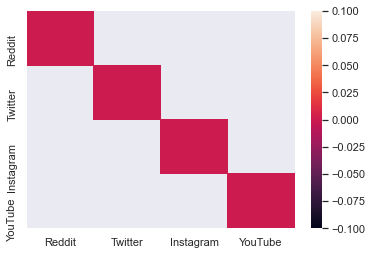

In [52]:
# Plot KL distances heatmap
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### $\chi^2$ Distance

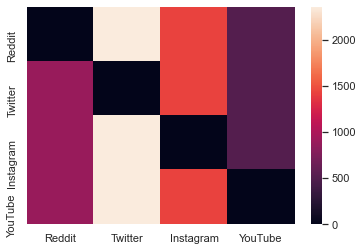

In [53]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### KS Distance

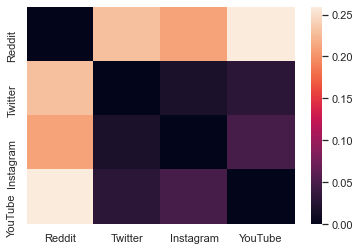

In [54]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
ax = sns.heatmap(div)
plt.show()

#### Wasserstein Distance

             Reddit   Twitter  Instagram   YouTube
Reddit     0.000000  0.588634   0.306266  0.373089
Twitter    0.588634  0.000000   0.298194  0.296031
Instagram  0.306266  0.298194   0.000000  0.094543
YouTube    0.373089  0.296031   0.094543  0.000000


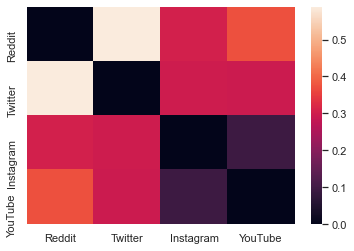

In [23]:
L = []
for p in df_lst:
    l = []
    for q in df_lst:
        l.append(Divergence(p['text'],q['text'], difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M, columns = title_lst, index = title_lst)
print(div)
ax = sns.heatmap(div)
plt.show()

#### Multidimensional Scaling

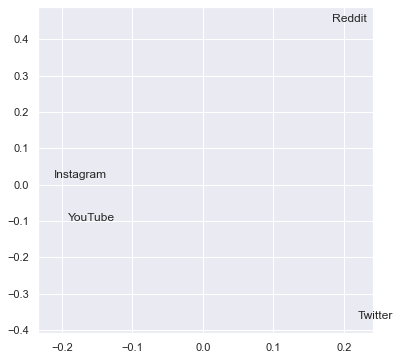

In [29]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(title_lst):
    ax.annotate(txt, (x[i],y[i]))

#### Jensen-Shannon Divergence

In [57]:
# Calculate Jensen-Shannon Divergences
rdt_twt_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, twtProbArray)
print("Reddit & Twitter: {}".format(rdt_twt_JSD))
rdt_ins_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, insProbArray)
print("Reddit & Instagram: {}".format(rdt_ins_JSD))
rdt_ytb_JSD = scipy.spatial.distance.jensenshannon(rdtProbArray, ytbProbArray)
print("Reddit & YouTube: {}\n".format(rdt_ytb_JSD))

twt_ins_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, insProbArray)
print("Twitter & Instagram: {}".format(twt_ins_JSD))
twt_ytb_JSD = scipy.spatial.distance.jensenshannon(twtProbArray, ytbProbArray)
print("Twitter & YouTube: {}".format(twt_ytb_JSD))
ins_ytb_JSD = scipy.spatial.distance.jensenshannon(insProbArray, ytbProbArray)
print("Instagram & YouTube: {}\n".format(ins_ytb_JSD))

Reddit & Twitter: 0.4479350819889657
Reddit & Instagram: 0.4377046908524279
Reddit & YouTube: 0.41335778031075665

Twitter & Instagram: 0.45946670026363373
Twitter & YouTube: 0.5033296661447721
Instagram & YouTube: 0.4548980692094881



## Discovering Patterns: Clusters & Topics 

#### Selecting Cluster Number

In [58]:
def getTFVects(df):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    return TFVectorizer, TFVects

In [59]:
from sklearn.cluster import KMeans
def plotSilhouette_revised(n_clusters, X, reduced_data):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

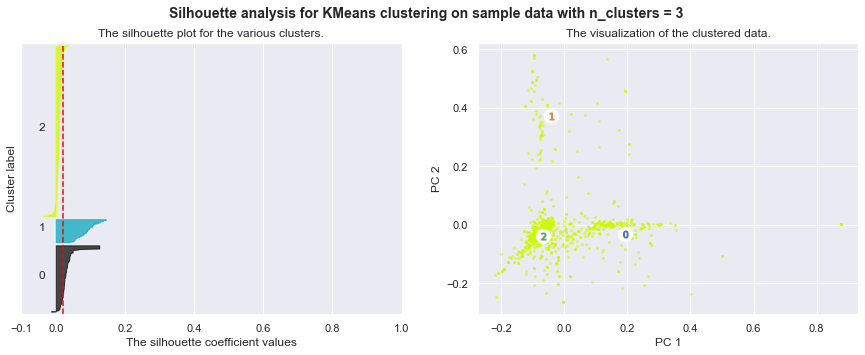

For n_clusters = 3, The average silhouette_score is : 0.022


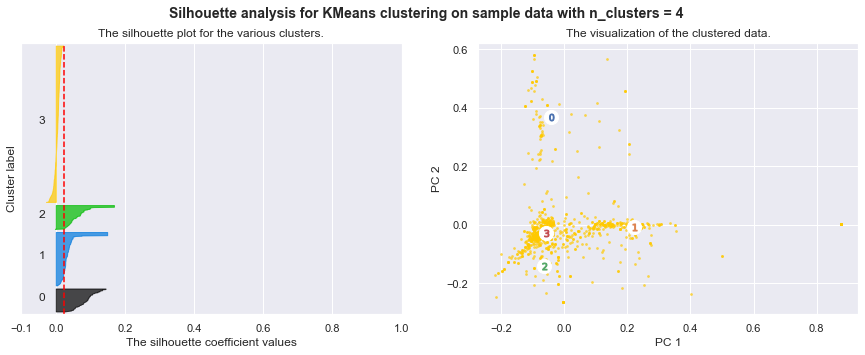

For n_clusters = 4, The average silhouette_score is : 0.024


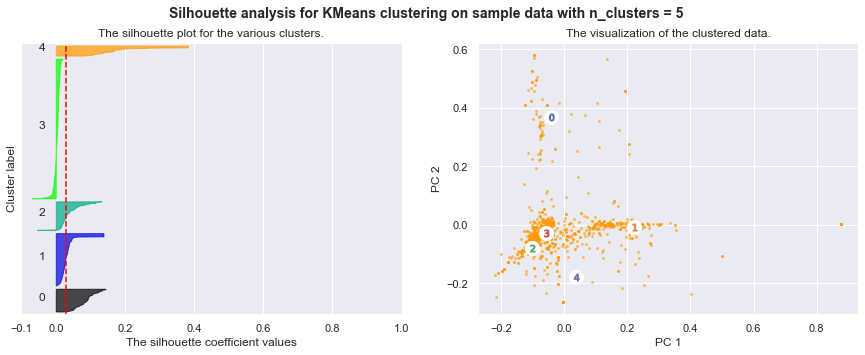

For n_clusters = 5, The average silhouette_score is : 0.029


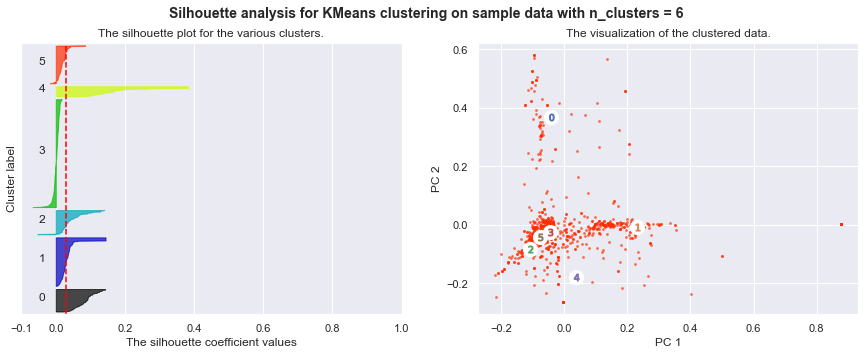

For n_clusters = 6, The average silhouette_score is : 0.030


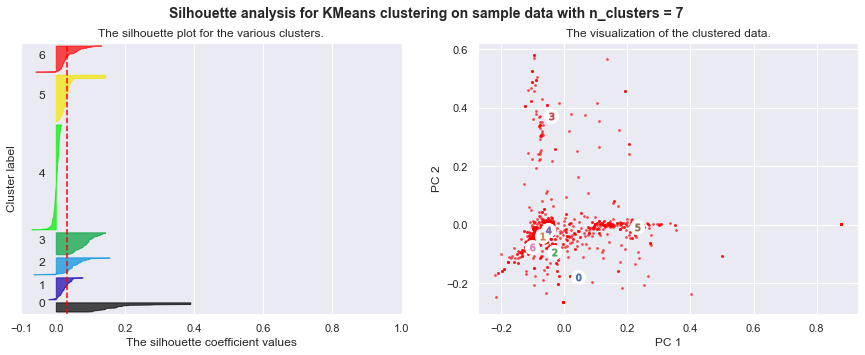

For n_clusters = 7, The average silhouette_score is : 0.032


In [60]:
cluster_num = [3, 4, 5, 6, 7]
rdtTFVectorizer, rdtTFVects = getTFVects(reddit)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(rdtTFVects.toarray())
    reduced_data = pca.transform(rdtTFVects.toarray())
    X = rdtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

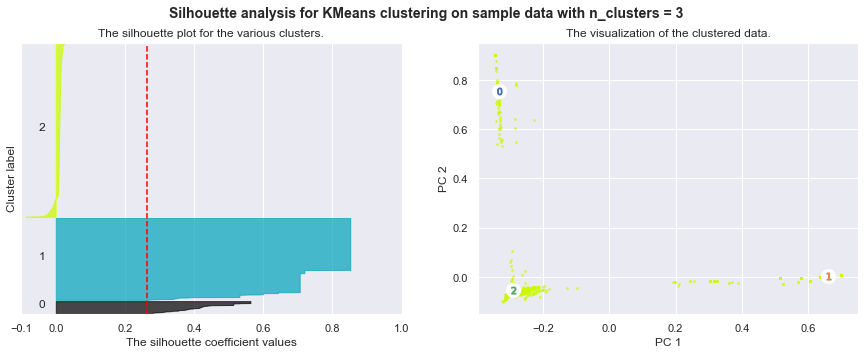

For n_clusters = 3, The average silhouette_score is : 0.263


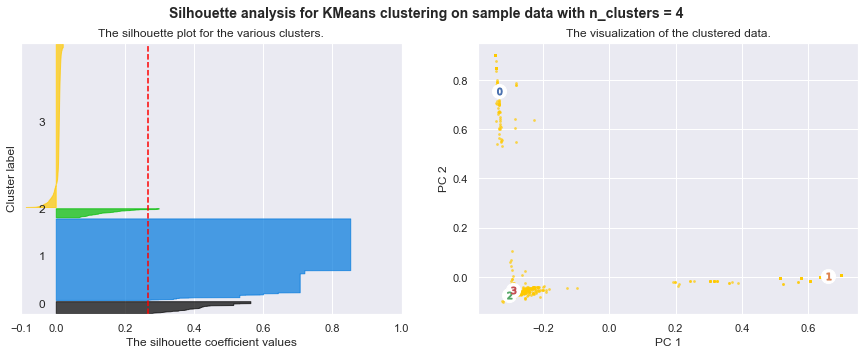

For n_clusters = 4, The average silhouette_score is : 0.267


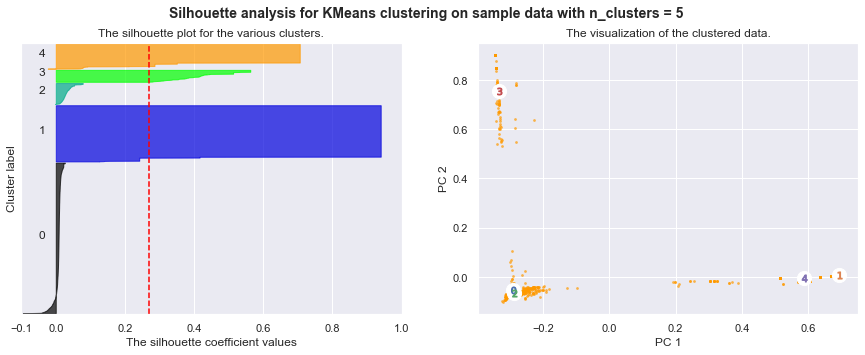

For n_clusters = 5, The average silhouette_score is : 0.268


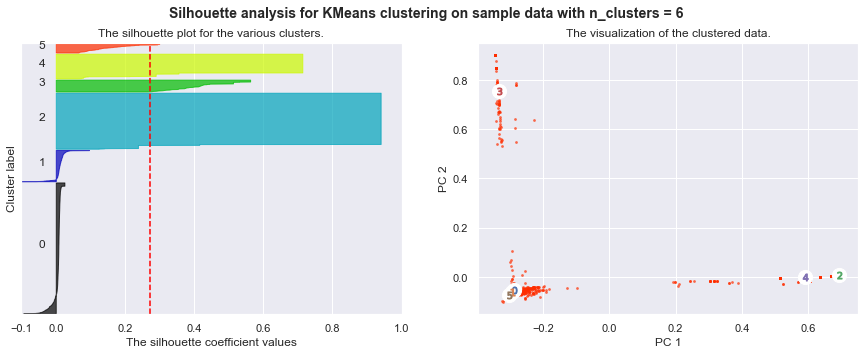

For n_clusters = 6, The average silhouette_score is : 0.271


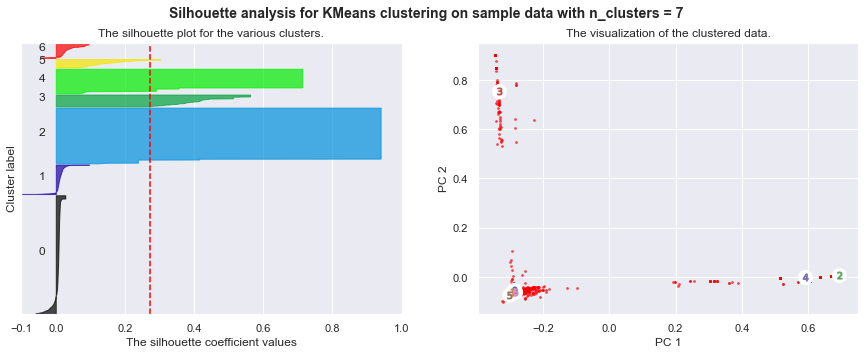

For n_clusters = 7, The average silhouette_score is : 0.273


In [61]:
twtTFVectorizer, twtTFVects = getTFVects(twitter)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(twtTFVects.toarray())
    reduced_data = pca.transform(twtTFVects.toarray())
    X = twtTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

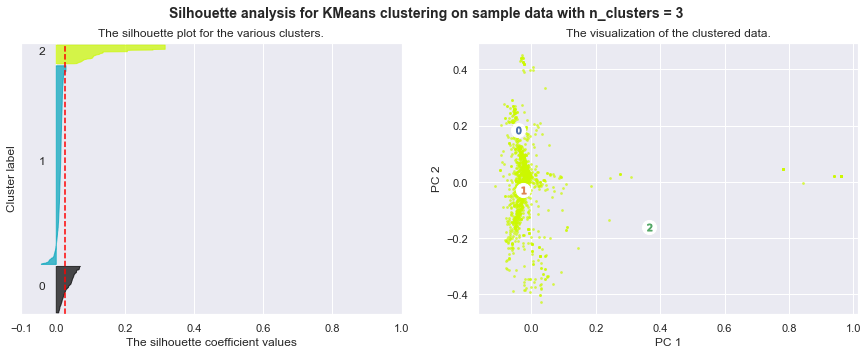

For n_clusters = 3, The average silhouette_score is : 0.026


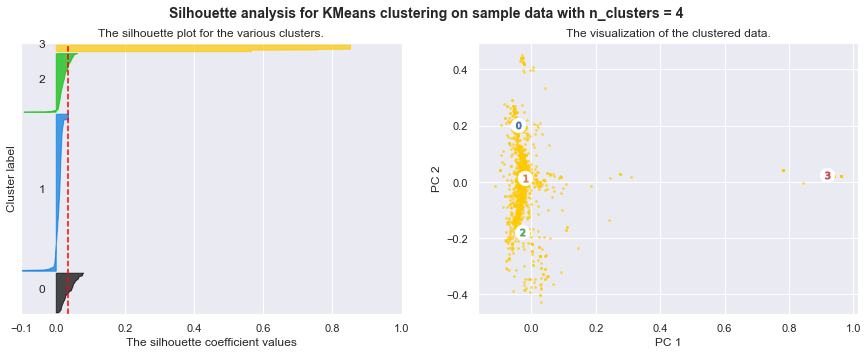

For n_clusters = 4, The average silhouette_score is : 0.036


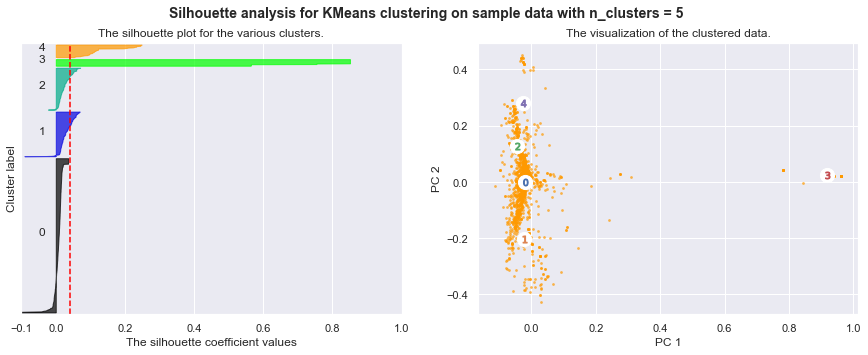

For n_clusters = 5, The average silhouette_score is : 0.040


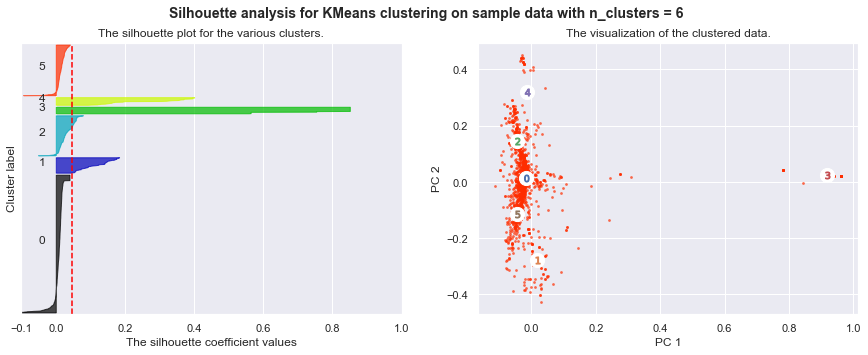

For n_clusters = 6, The average silhouette_score is : 0.046


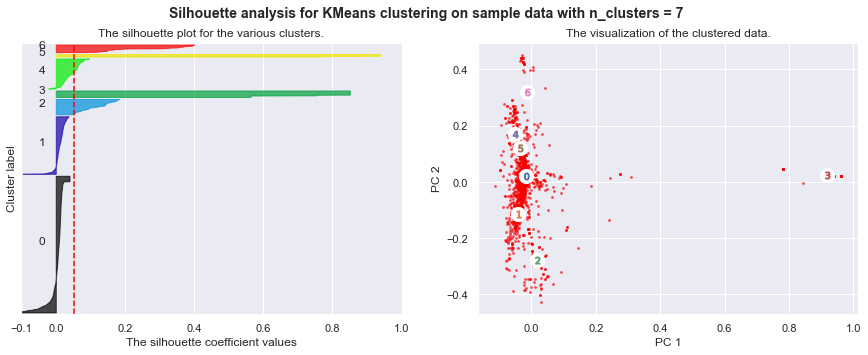

For n_clusters = 7, The average silhouette_score is : 0.053


In [62]:
insTFVectorizer, insTFVects = getTFVects(ins)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(insTFVects.toarray())
    reduced_data = pca.transform(insTFVects.toarray())
    X = insTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

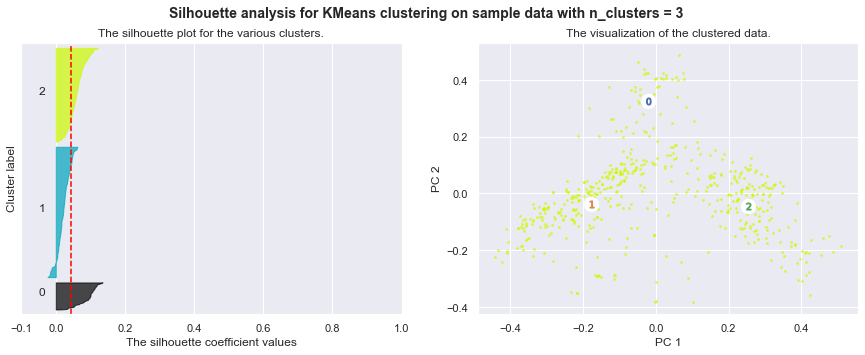

For n_clusters = 3, The average silhouette_score is : 0.043


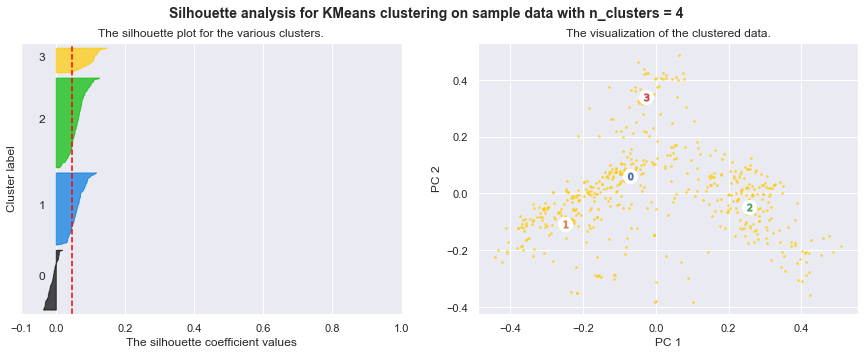

For n_clusters = 4, The average silhouette_score is : 0.048


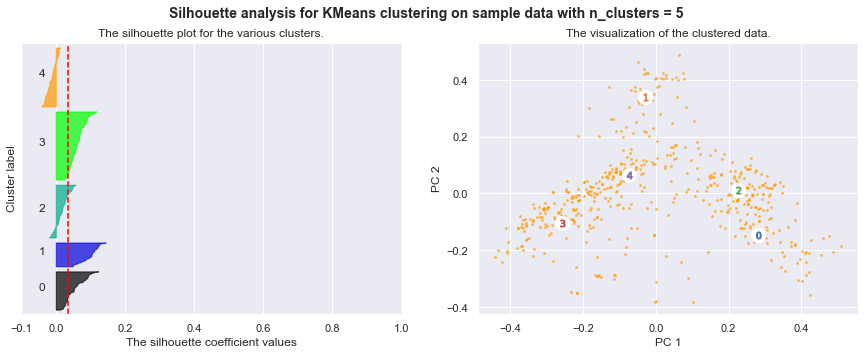

For n_clusters = 5, The average silhouette_score is : 0.036


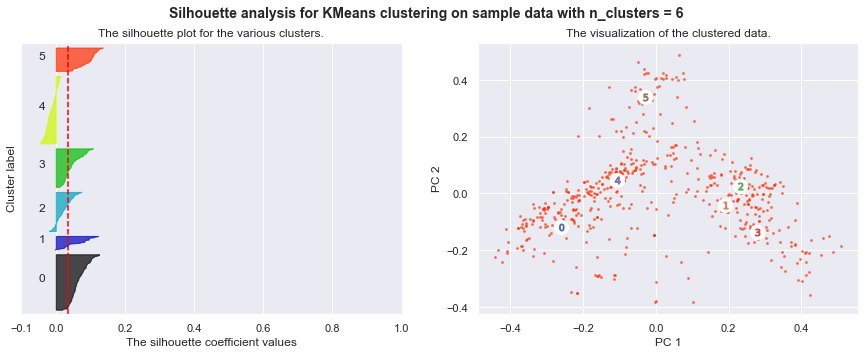

For n_clusters = 6, The average silhouette_score is : 0.036


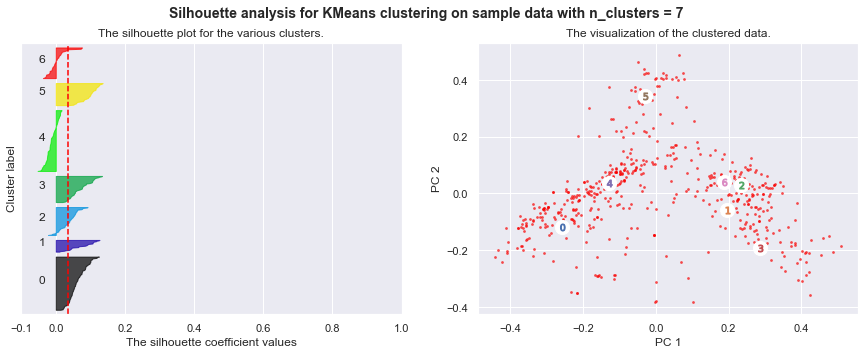

For n_clusters = 7, The average silhouette_score is : 0.037


In [63]:
ytbTFVectorizer, ytbTFVects = getTFVects(youtube)
for n in cluster_num:
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(ytbTFVects.toarray())
    reduced_data = pca.transform(ytbTFVects.toarray())
    X = ytbTFVects.toarray()
    plotSilhouette_revised(n, X, reduced_data)

#### Flat Clustering with $K$-means

In [64]:
colordict = {0: 'plum', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'red', 6: 'purple'}
def kMeanClustering(df, n):
    TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.50, max_features=1000, 
                                                           min_df=3, stop_words='english', norm='l2')
    TFVects = TFVectorizer.fit_transform(df['text'])
    km = sklearn.cluster.KMeans(n_clusters=n, init='k-means++')
    km.fit(TFVects.toarray())
    
    print("Evaluations")
    print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df['text'], km.labels_)))
    print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df['text'], km.labels_)))
    print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df['text'], km.labels_)))
    print("Adjusted Rand Score: {:0.3f}\n".format(sklearn.metrics.adjusted_rand_score(df['text'], km.labels_)))
    
    # Distinguish features of the clusters
    print("Top terms per cluster:")
    terms = TFVectorizer.get_feature_names()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(n):
        print("Cluster %d:" % i)
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print('\n')
    
    df['kmeans_predictions'] = km.labels_
    colors = [colordict[c] for c in df['kmeans_predictions']]
    
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components=n).fit(TFVects.toarray())
    reduced_data = pca.transform(TFVects.toarray())
    components = pca.components_
    keyword_ids = list(set(order_centroids[:,:5].flatten()))
    words = [terms[i] for i in keyword_ids]
    x = components[:,keyword_ids][0,:]
    y = components[:,keyword_ids][1,:]
    
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
    for i, word in enumerate(words):
        ax.annotate(word, (x[i],y[i]))   
    plt.xticks(())
    plt.yticks(())
    plt.title('True Classes')
    plt.show()
    return df

Evaluations
Homogeneity: 0.242
Completeness: 1.000
V-measure: 0.390
Adjusted Rand Score: 0.005

Top terms per cluster:
Cluster 0:
 curry
 stephen
 armour
 steph
 shoe
 fumbled
 mistake
 look
 billion
 14


Cluster 1:
 know
 shoes
 does
 new
 buy
 want
 model
 shoe
 pair
 got


Cluster 2:
 ua
 just
 shirt
 like
 shorts
 size
 shirts
 project
 ve
 compression


Cluster 3:
 armour
 new
 adidas
 brand
 sports
 2020
 year
 announces
 kevin
 mlb


Cluster 4:
 com
 https
 help
 www
 survey
 armour
 imgur
 underarmour
 identify
 en


Cluster 5:
 40
 codes
 code
 100
 discount
 promo
 pm
 thanks
 coupon
 ambassador




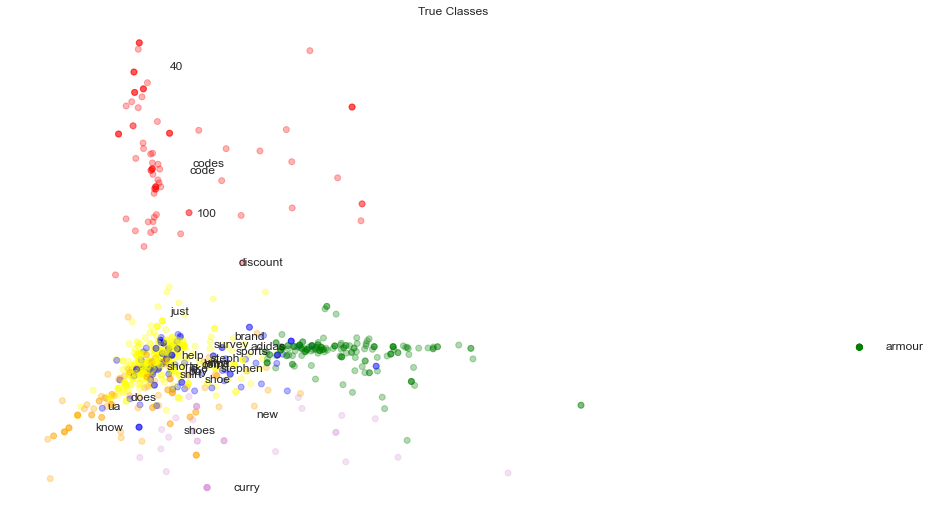

In [65]:
reddit = kMeanClustering(reddit, 6)

Evaluations
Homogeneity: 0.221
Completeness: 1.000
V-measure: 0.363
Adjusted Rand Score: 0.168

Top terms per cluster:
Cluster 0:
 armour
 therock
 projectrock
 just
 shoes
 like
 amp
 running
 mrcracknell
 stephencurry30


Cluster 1:
 loving
 share
 poshmarkapp
 items
 good
 check
 poshmark
 fashion
 angelsposhshop
 kellis1986


Cluster 2:
 nike
 adidas
 puma
 brands
 like
 jessphoenix2018
 sports
 rt
 just
 shoes


Cluster 3:
 aawashington_3
 kirbyhocutt
 ttucoachwells
 teagan_ttu
 texastechfb
 congrats
 congratulations
 ashton
 welcome
 luck


Cluster 4:
 style
 shopmycloset
 fashion
 poshmark
 loving
 share
 poshmarkapp
 items
 good
 check


Cluster 5:
 rt
 new
 armour
 ua
 amp
 shop
 season
 therock
 men
 time




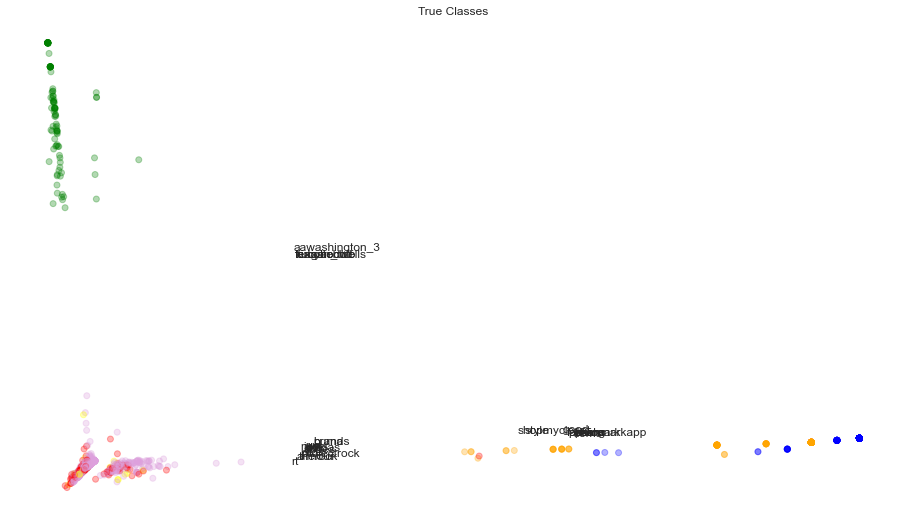

In [66]:
twitter = kMeanClustering(twitter, 6)

Evaluations
Homogeneity: 0.175
Completeness: 1.000
V-measure: 0.298
Adjusted Rand Score: 0.001

Top terms per cluster:
Cluster 0:
 curry
 currybrand
 kicks
 uabasketball
 sneakers
 stephencurry
 curry8
 stephcurry
 dubnation
 basketball


Cluster 1:
 theworkoutloverz
 follow
 shoutouter
 toptags
 so4so
 soforso
 shoutout4shoutout
 shoutoutforshoutout
 s4s
 shout


Cluster 2:
 nike
 adidas
 armour
 puma
 new
 reebok
 day
 fashion
 size
 women


Cluster 3:
 therock
 projectrock
 dwaynejohnson
 dwaynetherockjohnson
 follow
 wwe
 vindiesel
 fastandfurious
 hollywood
 dwaynejohnsonofficial


Cluster 4:
 run
 running
 runnersofinstagram
 runningmotivation
 runner
 garmin
 fitness
 uarunning
 miles
 asics


Cluster 5:
 workout
 fitness
 gym
 fitnessmotivation
 motivation
 training
 fit
 bodybuilding
 gymmotivation
 gymlife




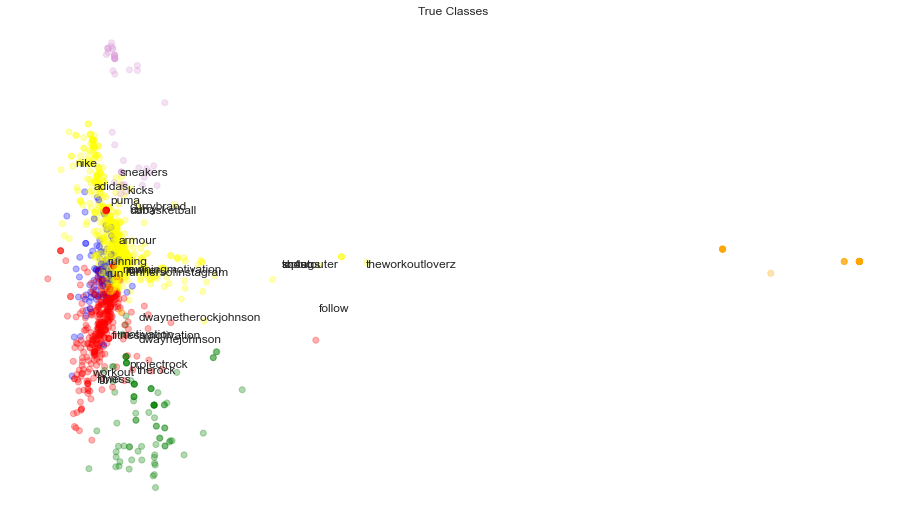

In [67]:
ins = kMeanClustering(ins, 6)

Evaluations
Homogeneity: 0.290
Completeness: 1.000
V-measure: 0.450
Adjusted Rand Score: 0.000

Top terms per cluster:
Cluster 0:
 shoe
 run
 shoes
 golf
 ve
 kind
 running
 know
 speed
 think


Cluster 1:
 feet
 music
 lace
 heel
 richard
 outsole
 sku
 com
 upper
 ua


Cluster 2:
 music
 new
 band
 armor
 body
 time
 performance
 want
 ua
 right


Cluster 3:
 bag
 backpack
 pocket
 pockets
 main
 shoulder
 soft
 padded
 nice
 space


Cluster 4:
 just
 know
 don
 kind
 going
 ll
 little
 right
 think
 ve


Cluster 5:
 gonna
 ve
 lots
 super
 support
 comfort
 ua
 calm
 foot
 giving


Cluster 6:
 shoe
 footbed
 music
 upper
 design
 flexible
 tongue
 charged
 synthetic
 lace




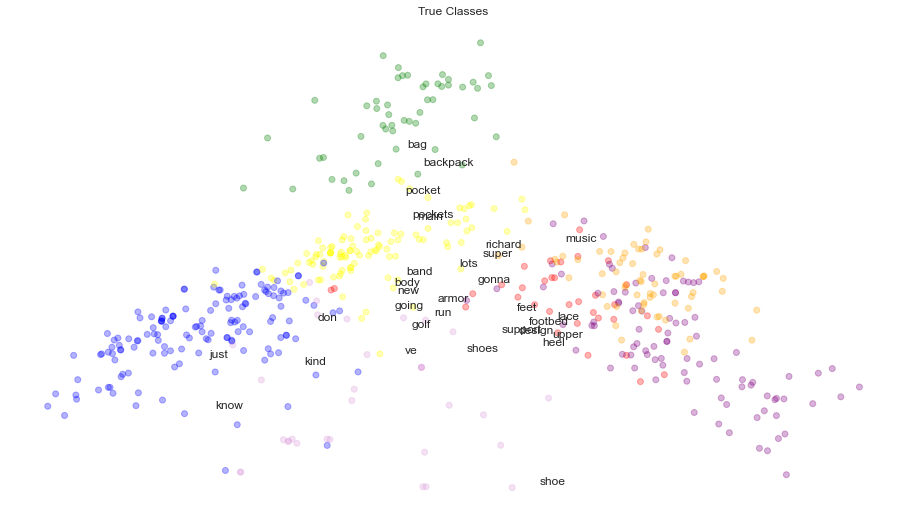

In [68]:
youtube = kMeanClustering(youtube, 7)

#### Hierarchical Cluster

In [69]:
def getLinkageMatrix(TFVects):
    CoocMat = TFVects * TFVects.T
    CoocMat.setdiag(0)
    matrix = scipy.cluster.hierarchy.ward(CoocMat[:50, :50].toarray())
    return matrix

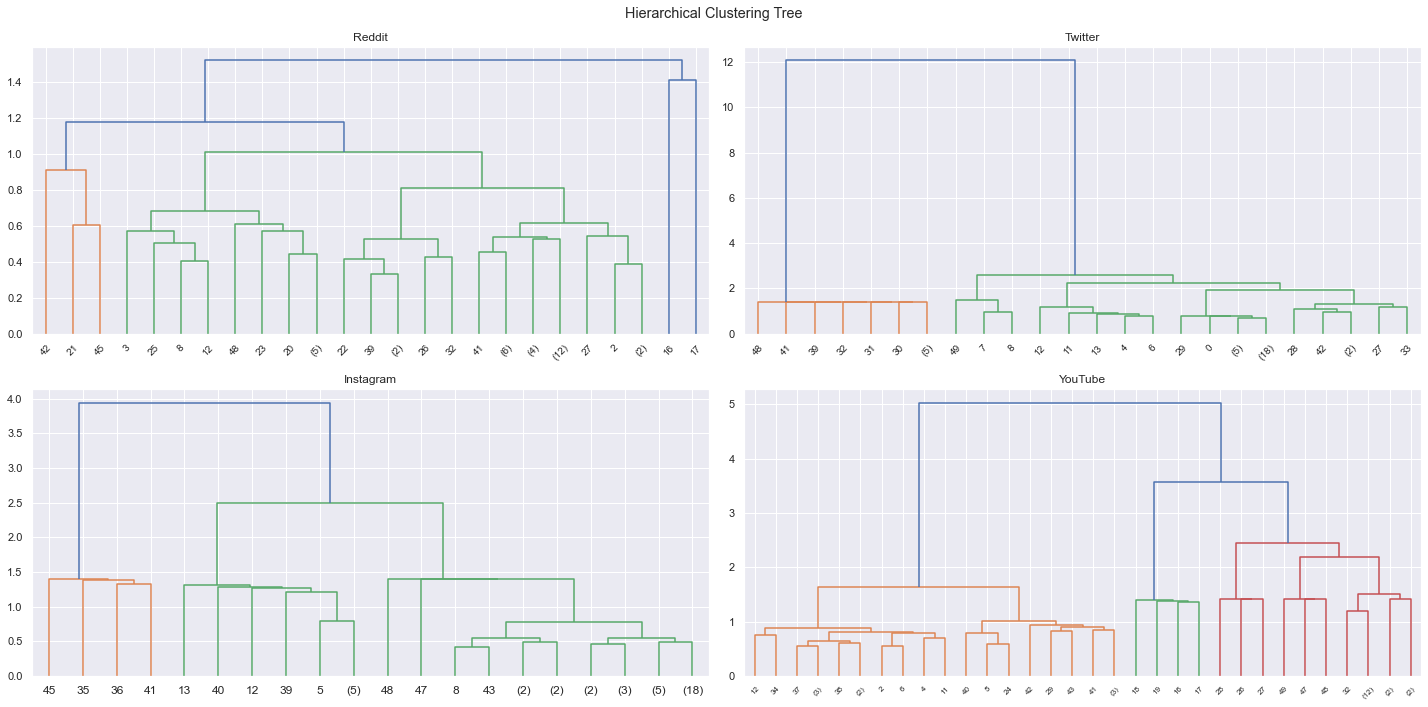

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle("Hierarchical Clustering Tree")

rdt_matrix = getLinkageMatrix(rdtTFVects)
scipy.cluster.hierarchy.dendrogram(rdt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 0])
axs[0, 0].set_title("Reddit")
twt_matrix = getLinkageMatrix(twtTFVects)
scipy.cluster.hierarchy.dendrogram(twt_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[0, 1])
axs[0, 1].set_title("Twitter")

ins_matrix = getLinkageMatrix(insTFVects)
scipy.cluster.hierarchy.dendrogram(ins_matrix, p=6, truncate_mode='level', get_leaves=True, ax=axs[1, 0])
axs[1, 0].set_title("Instagram")
ytb_matrix = getLinkageMatrix(ytbTFVects)
scipy.cluster.hierarchy.dendrogram(ytb_matrix, p=5, truncate_mode='level', get_leaves=True, ax=axs[1, 1])
axs[1, 1].set_title("YouTube")

fig.tight_layout()
plt.show()

In [71]:
def calculateWaldClustering(TFVects, title, n, df):
    CoocMat = TFVects * TFVects.T
    linkage_matrix_full = scipy.cluster.hierarchy.ward(CoocMat.toarray())
    hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, n, 'maxclust')
    print("Silhouetter score for " + title + " is " + 
          str(sklearn.metrics.silhouette_score(CoocMat, hierarchicalClusters_full)))
    df['wald_predictions'] = hierarchicalClusters_full
    return df

In [72]:
reddit = calculateWaldClustering(rdtTFVects, "Reddit", 6, reddit)
twitter = calculateWaldClustering(twtTFVects, "Twitter", 6, twitter)
ins = calculateWaldClustering(insTFVects, "Instagram", 6, ins)
youtube = calculateWaldClustering(ytbTFVects, "YouTube", 6, youtube)

Silhouetter score for Reddit is 0.09289439455698624
Silhouetter score for Twitter is 0.44333998945571
Silhouetter score for Instagram is 0.10133532850659206
Silhouetter score for YouTube is 0.15540938295105697


#### Genism

In [73]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

reddit['reduced_tokens'] = reddit['normalized_tokens'].apply(lambda x: dropMissing(x, rdtTFVectorizer.vocabulary_.keys()))
twitter['reduced_tokens'] = twitter['normalized_tokens'].apply(lambda x: dropMissing(x, twtTFVectorizer.vocabulary_.keys()))
ins['reduced_tokens'] = ins['normalized_tokens'].apply(lambda x: dropMissing(x, insTFVectorizer.vocabulary_.keys()))
youtube['reduced_tokens'] = youtube['normalized_tokens'].apply(lambda x: dropMissing(x, ytbTFVectorizer.vocabulary_.keys()))

In [74]:
def conductLDAModel(df, title):
    dictionary = gensim.corpora.Dictionary(df['reduced_tokens'])
    corpus = [dictionary.doc2bow(text) for text in df['reduced_tokens']]
    gensim.corpora.MmCorpus.serialize(title, corpus)
    mmcorpus = gensim.corpora.MmCorpus(title)
    lda = gensim.models.ldamodel.LdaModel(corpus=mmcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
    return dictionary, lda

In [75]:
rdt_dict, rdt_lda = conductLDAModel(reddit, "Reddit")
twt_dict, twt_lda = conductLDAModel(twitter, "Twitter")
ins_dict, ins_lda = conductLDAModel(ins, "Instagram")
ytb_dict, ytb_lda = conductLDAModel(youtube, "YouTube")

#### Reddit

In [76]:
rdt_ldaDF = pd.DataFrame({'upvotes' : reddit['upvotes'], 
                         'topics' : [rdt_lda[rdt_dict.doc2bow(l)] for l in reddit['reduced_tokens']]})
topicsProbDict = {i : [0] * len(rdt_ldaDF) for i in range(rdt_lda.num_topics)}

for index, topicTuples in enumerate(rdt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(rdt_lda.num_topics):
    rdt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

rdt_ldaDF.head()

,upvotes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,3,"[(6, 0.94042844)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.940428,0.000000,0.000000,0.000000
1,3,"[(0, 0.20721571), (1, 0.72892827)]",0.207216,0.728928,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,"[(4, 0.63867366), (6, 0.33514106)]",0.000000,0.000000,0.000000,0.000000,0.638674,0.000000,0.335141,0.000000,0.000000,0.000000
3,1,"[(0, 0.098089024), (1, 0.09769159), (2, 0.1027...",0.098089,0.097692,0.102723,0.095144,0.103188,0.094788,0.111600,0.096525,0.102220,0.098031
4,12,"[(0, 0.012327247), (1, 0.012277074), (2, 0.887...",0.012327,0.012277,0.887237,0.011957,0.012968,0.011912,0.014025,0.012130,0.012846,0.012321


In [77]:
rdt_ldaDF.sort_values(by=['upvotes'], ascending=False, inplace=True)
rdt_ldaDFV = rdt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[:10][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

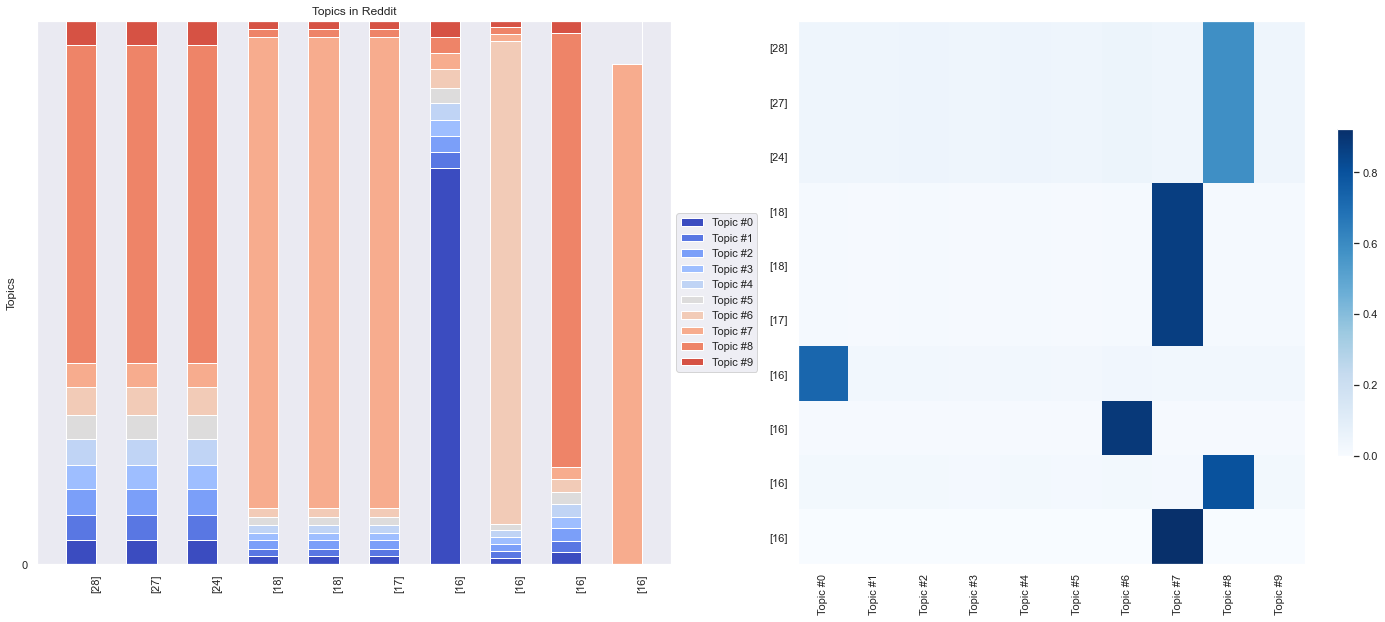

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [79]:
topicsDict = {}
for topicNum in range(rdt_lda.num_topics):
    topicWords = [w for w, p in rdt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,ua,armour,armour,armour,armour,ua,armour,ua,armour,armour
1,armour,ua,ua,like,ua,know,ua,code,curry,like
2,shoes,shoes,product,skin,know,shirt,shoes,shirt,know,size
3,rock,shoe,like,help,discount,looking,like,shirts,ua,shorts
4,new,curry,brand,loose,codes,buy,underarmour,like,compression,know
5,project,size,help,shirt,shoes,model,know,new,skin,ua
6,buy,help,new,want,time,help,new,armour,brand,looking
7,customer,ve,shorts,know,order,underarmour,comments,order,like,codes
8,running,hovr,feel,curry,got,compression,fit,thanks,factory,compression
9,thanks,wondering,year,shoe,ve,app,user,know,charged,jogger


In [80]:
rdt_ldaDFV = rdt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
rdt_ldaDFVisN = rdt_ldaDF[-10:][['upvotes']]
rdt_ldaDFVis = rdt_ldaDFV.values
rdt_ldaDFVisNames = rdt_ldaDFVisN.values

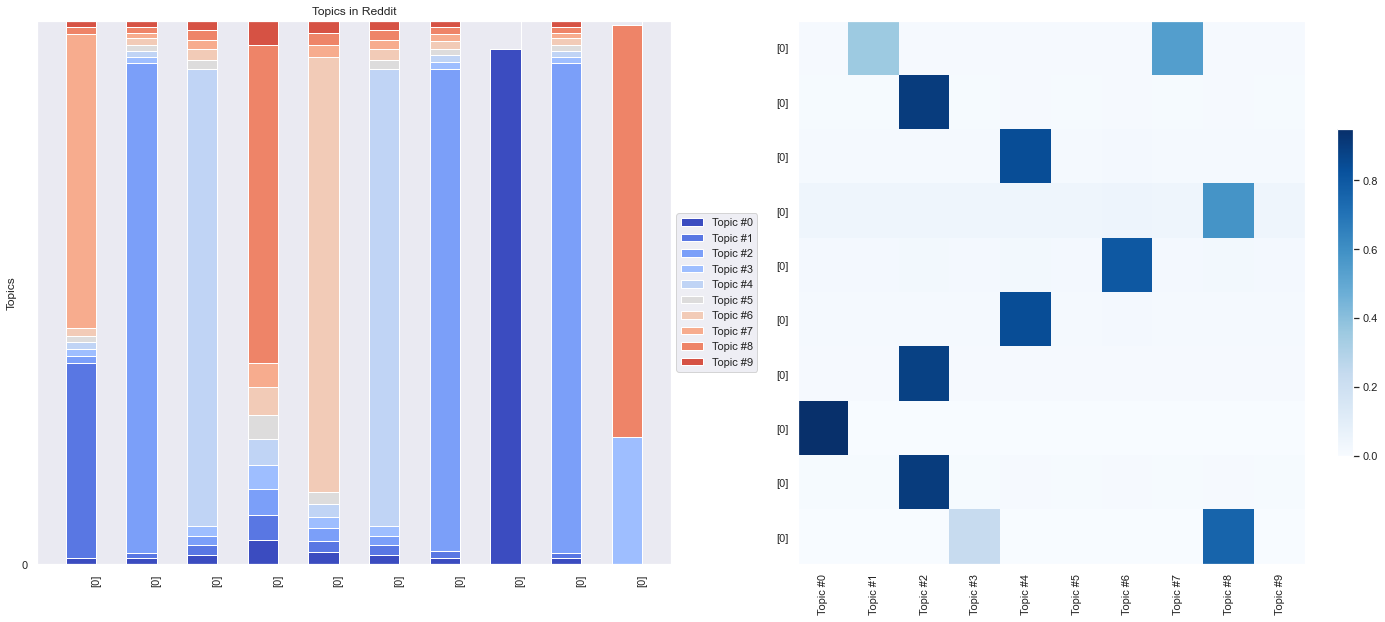

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = rdt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, rdt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += rdt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Reddit")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(rdt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(rdt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(rdt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(rdt_ldaDFVisNames);
ax2.set_xticks(np.arange(rdt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(rdt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Twitter

In [82]:
twt_ldaDF = pd.DataFrame({'favorite_cnt' : twitter['favorite_cnt'],
                         'topics' : [twt_lda[twt_dict.doc2bow(l)] for l in twitter['reduced_tokens']]})
topicsProbDict = {i : [0] * len(twt_ldaDF) for i in range(twt_lda.num_topics)}

for index, topicTuples in enumerate(twt_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(twt_lda.num_topics):
    twt_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

twt_ldaDF.head()

,favorite_cnt,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0,"[(0, 0.024764093), (1, 0.26381966), (2, 0.4296...",0.024764,0.263820,0.429672,0.017421,0.016515,0.016795,0.017059,0.017005,0.016283,0.180667
1,0,"[(0, 0.87377703), (1, 0.014365073), (2, 0.0138...",0.873777,0.014365,0.013843,0.014445,0.013694,0.013926,0.014144,0.014100,0.013501,0.014204
2,0,"[(0, 0.1399153), (1, 0.09788426), (2, 0.094326...",0.139915,0.097884,0.094326,0.098428,0.093311,0.094891,0.096380,0.096077,0.091999,0.096789
3,0,"[(0, 0.905895), (1, 0.010709829), (2, 0.010320...",0.905895,0.010710,0.010321,0.010769,0.010210,0.010382,0.010545,0.010512,0.010066,0.010590
4,0,"[(0, 0.04207843), (1, 0.3773825), (2, 0.028365...",0.042078,0.377382,0.028366,0.029599,0.379390,0.028535,0.028983,0.028892,0.027666,0.029107


In [83]:
twt_ldaDF.sort_values(by=['favorite_cnt'], ascending=False, inplace=True)
twt_ldaDFV = twt_ldaDF[:10][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[:10][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

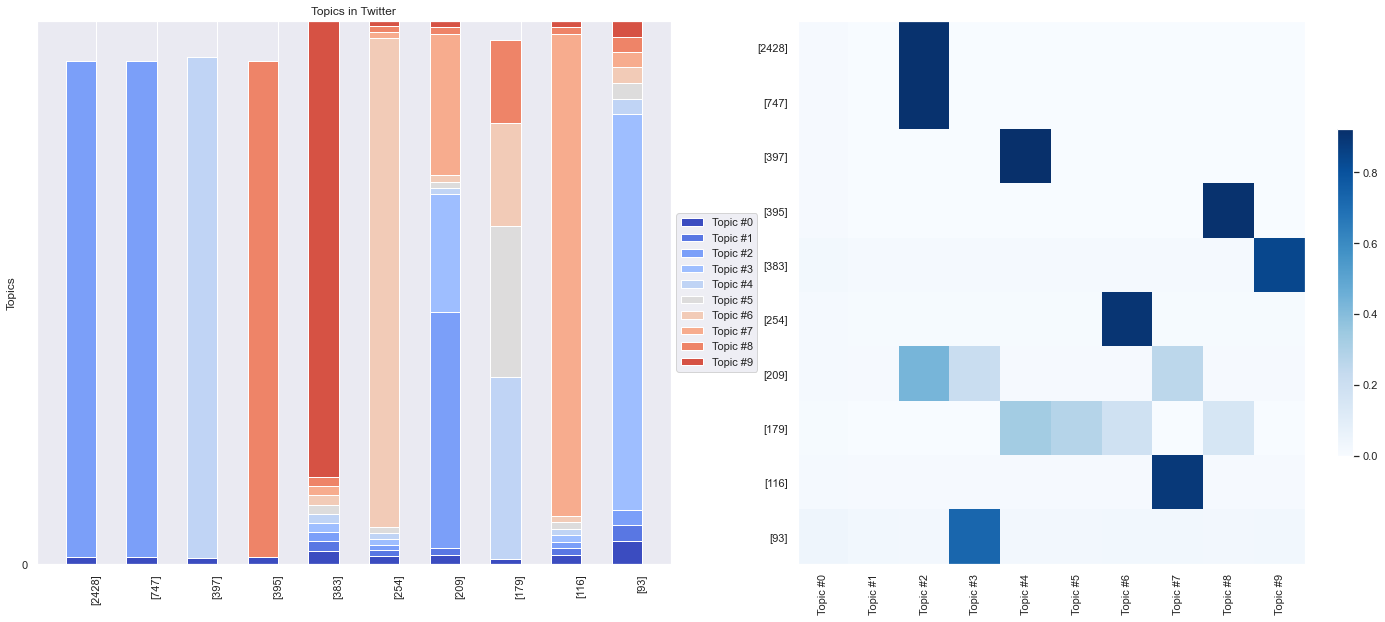

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [85]:
topicsDict = {}
for topicNum in range(twt_lda.num_topics):
    topicWords = [w for w, p in twt_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,check,shoes,shop,rock,check,thanks,kevin,check,comfort,investors
1,loving,know,love,time,poshmark,nice,plank,poshmark,armour,stock
2,share,mask,amp,armour,share,new,girls,share,amp,company
3,poshmark,running,armour,sold,loving,shirts,soon,loving,camp,armour
4,fashion,wearing,new,check,size,lot,great,fashion,pairs,shoes
5,style,like,shoe,sir,great,sold,dropped,style,screen,recently
6,shopmycloset,training,day,high,fashion,amp,tough,shopmycloset,run,football
7,spieth,need,bruce,use,video,boys,hey,listen,coach,check
8,allegedly,amazing,lee,code,listing,batazr,downtrend,episode,football,ua
9,revenue,logo,complete,fashion,closet,printed,indicator,runners,morning,amp


In [86]:
twt_ldaDFV = twt_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
twt_ldaDFVisN = twt_ldaDF[-10:][['favorite_cnt']]
twt_ldaDFVis = twt_ldaDFV.values
twt_ldaDFVisNames = twt_ldaDFVisN.values

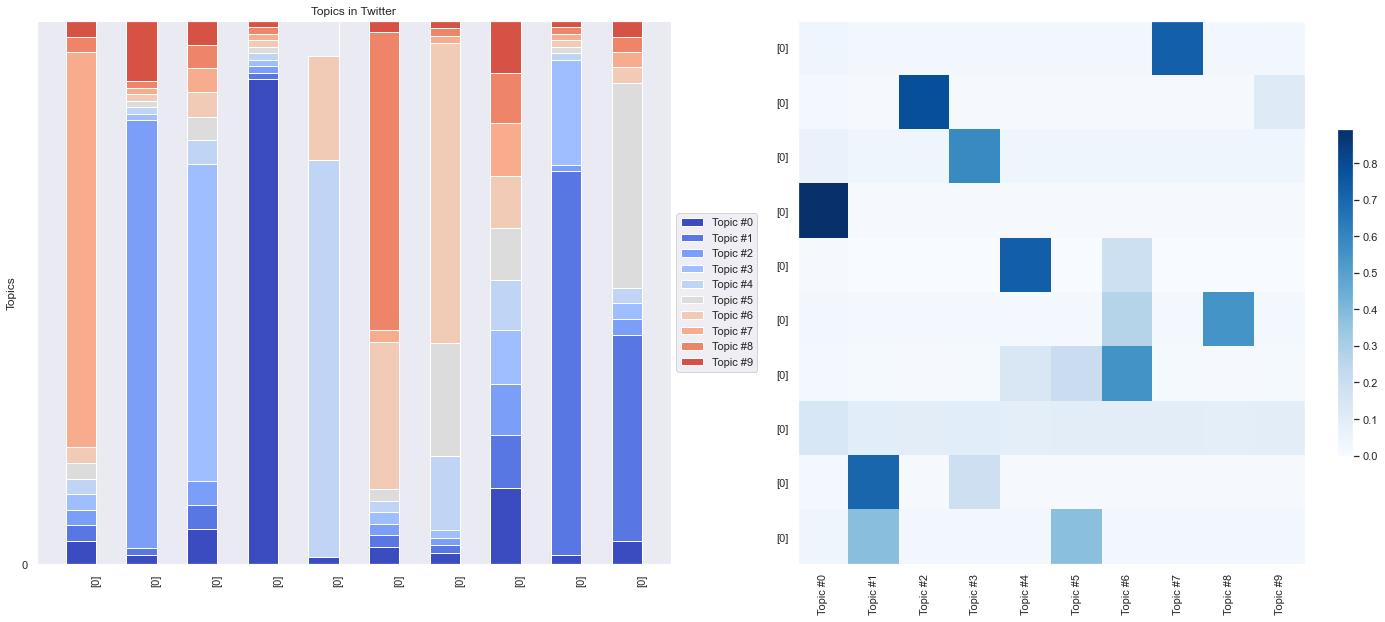

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = twt_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, twt_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += twt_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Twitter")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(twt_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(twt_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(twt_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(twt_ldaDFVisNames);
ax2.set_xticks(np.arange(twt_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(twt_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### Instagram

In [88]:
ins_ldaDF = pd.DataFrame({'likes' : ins['likes'],
                         'topics' : [ins_lda[ins_dict.doc2bow(l)] for l in ins['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ins_ldaDF) for i in range(ins_lda.num_topics)}

for index, topicTuples in enumerate(ins_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ins_lda.num_topics):
    ins_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ins_ldaDF.head()

,likes,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,5637,"[(0, 0.029003456), (1, 0.03127745), (2, 0.0309...",0.029003,0.031277,0.030999,0.02871,0.028449,0.731463,0.031212,0.028438,0.029405,0.031045
2,5988,"[(0, 0.50965995), (4, 0.44111174)]",0.509660,0.000000,0.000000,0.00000,0.441112,0.000000,0.000000,0.000000,0.000000,0.000000
3,191,"[(1, 0.010060877), (6, 0.9145056)]",0.000000,0.010061,0.000000,0.00000,0.000000,0.000000,0.914506,0.000000,0.000000,0.000000
4,184,"[(9, 0.9453422)]",0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.945342
5,1403,"[(1, 0.45245713), (5, 0.21299773), (6, 0.31669...",0.000000,0.452457,0.000000,0.00000,0.000000,0.212998,0.316698,0.000000,0.000000,0.000000


In [89]:
ins_ldaDF = ins_ldaDF[ins_ldaDF['likes'].astype(str).str.isdigit()]

In [90]:
ins_ldaDF.sort_values(by=['likes'], ascending=False, inplace=True)
ins_ldaDFV = ins_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[:10][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

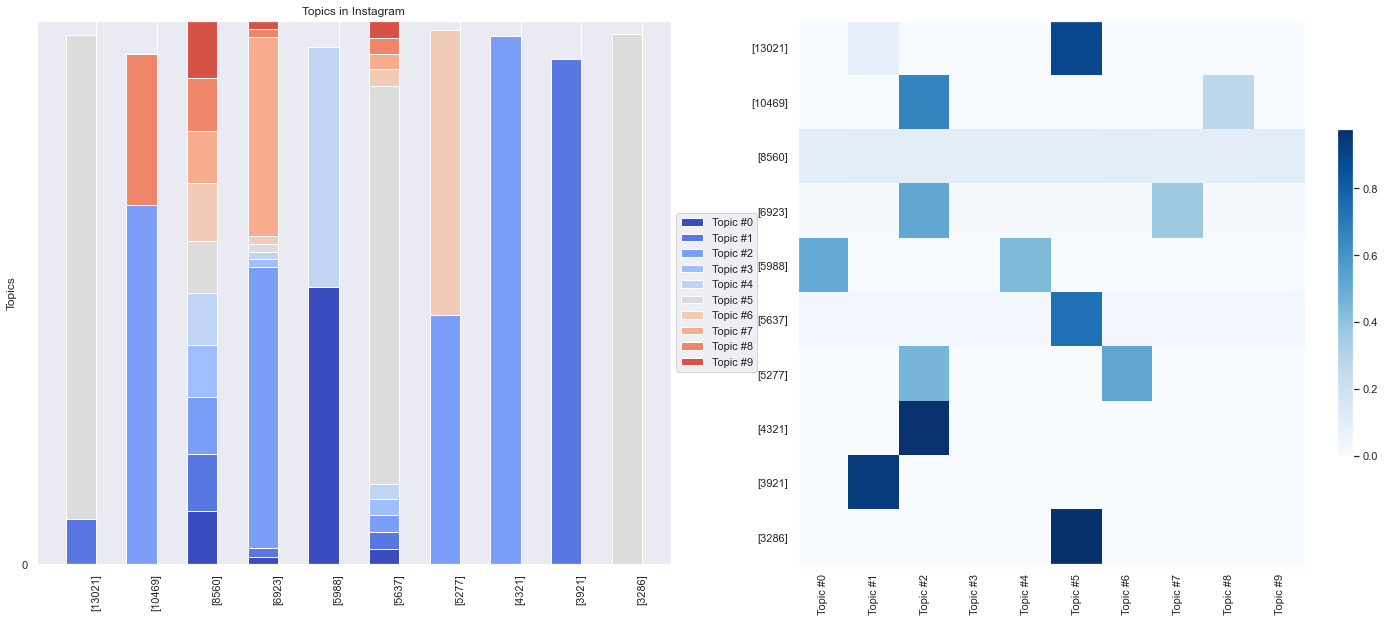

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [92]:
topicsDict = {}
for topicNum in range(ins_lda.num_topics):
    topicWords = [w for w, p in ins_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,workout,follow,fitness,nike,nike,fitness,fitness,gym,nike,nike
1,fitness,nike,workout,workout,armour,dwaynetherockjohnson,gym,fitness,today,adidas
2,gym,gym,nike,follow,baseball,dwaynejohnson,workout,day,adidas,gym
3,training,fitness,follow,day,sports,nike,run,training,puma,fitness
4,workoutmotivation,workout,gym,puma,adidas,projectrock,bodybuilding,nike,fitness,sneakers
5,motivation,instagood,fit,reps,fitness,vindiesel,love,motivation,life,running
6,time,post,day,gainwithmtaaraw,photooftheday,sneakers,new,workout,gym,armour
7,run,so4so,fitnessmotivation,sneakers,training,thefateofthefurious,nike,work,fitnessmotivation,puma
8,happy,shoutoutforshoutout,like,adidas,workout,therockfanpage,today,sports,armour,sport
9,running,shoutouts,run,today,puma,dwaynejohnsonofficial,motivation,fitnessmotivation,lgm,fashion


In [93]:
ins_ldaDFV = ins_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ins_ldaDFVisN = ins_ldaDF[-10:][['likes']]
ins_ldaDFVis = ins_ldaDFV.values
ins_ldaDFVisNames = ins_ldaDFVisN.values

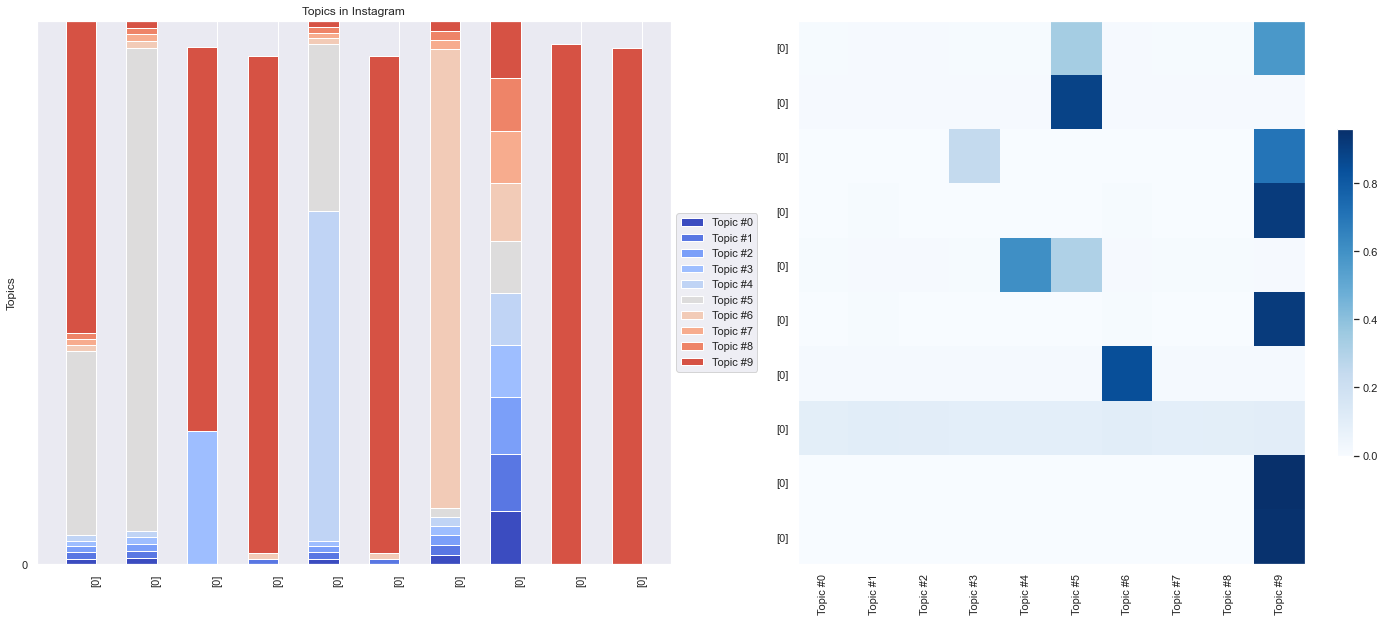

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ins_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ins_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ins_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "Instagram")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ins_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ins_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ins_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ins_ldaDFVisNames);
ax2.set_xticks(np.arange(ins_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ins_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### YouTube

In [95]:
ytb_ldaDF = pd.DataFrame({'likeCount' : youtube['likeCount'],
                         'topics' : [ytb_lda[ytb_dict.doc2bow(l)] for l in youtube['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ytb_ldaDF) for i in range(ytb_lda.num_topics)}

for index, topicTuples in enumerate(ytb_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(ytb_lda.num_topics):
    ytb_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ytb_ldaDF.head()

,likeCount,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
2,10,"[(1, 0.43773195), (4, 0.13597079), (9, 0.41930...",0.0,0.437732,0.000000,0.0,0.135971,0.0,0.0,0.0,0.0,0.419306
3,2,"[(2, 0.36199343), (9, 0.58775926)]",0.0,0.000000,0.361993,0.0,0.000000,0.0,0.0,0.0,0.0,0.587759
4,0,"[(1, 0.9662694)]",0.0,0.966269,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
5,Not available,"[(1, 0.64748627), (9, 0.30545843)]",0.0,0.647486,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.305458
8,1,"[(1, 0.54435295), (2, 0.41912097)]",0.0,0.544353,0.419121,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [96]:
ytb_ldaDF = ytb_ldaDF[ytb_ldaDF.likeCount.str.isnumeric()]
ytb_ldaDF["likeCount"] = ytb_ldaDF["likeCount"].astype(str).astype(int)

In [97]:
ytb_ldaDF.sort_values(by=['likeCount'], ascending=False, inplace=True)
ytb_ldaDFV = ytb_ldaDF[:10][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[:10][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

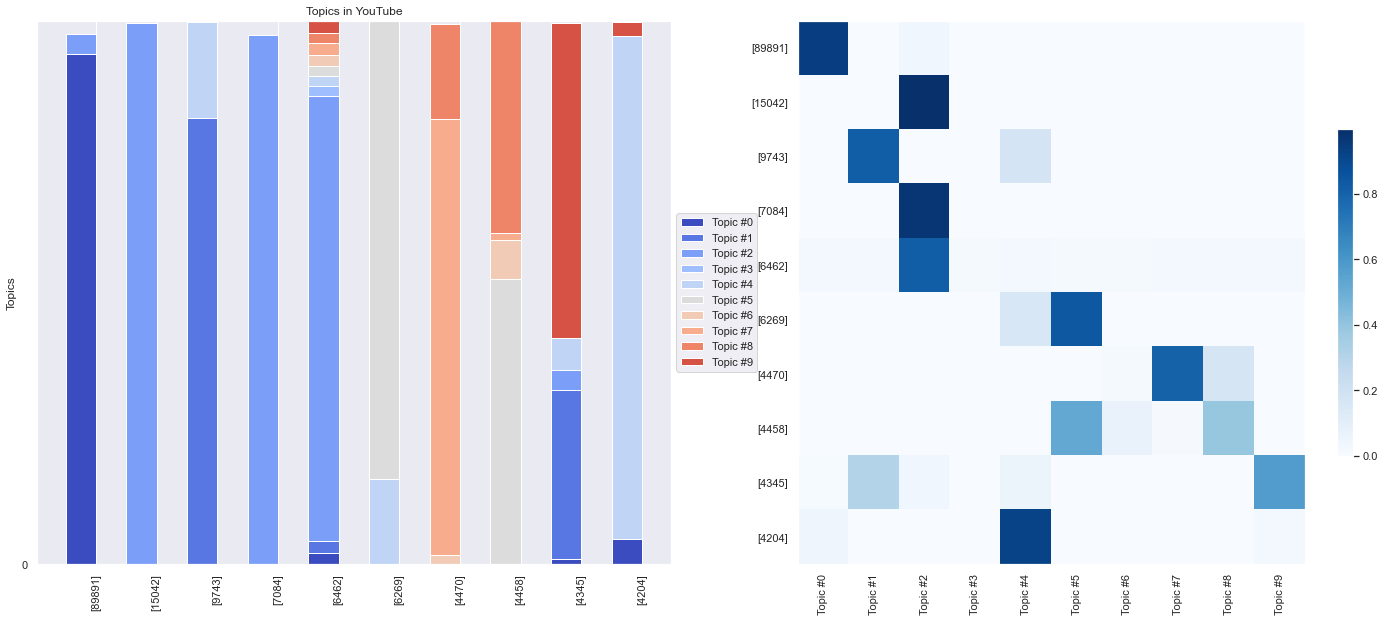

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

In [99]:
topicsDict = {}
for topicNum in range(ytb_lda.num_topics):
    topicWords = [w for w, p in ytb_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,man,right,great,man,ve,right,time,going,right,going
1,little,going,think,going,ant,time,think,said,time,kind
2,way,shoe,right,ve,ants,think,going,think,professor,right
3,think,ve,lot,game,look,bit,right,man,said,little
4,right,think,bit,right,queen,students,ve,right,students,time
5,going,time,time,think,time,said,way,kind,way,ve
6,bit,let,guys,school,kind,professor,people,professor,student,bit
7,ve,bit,going,time,think,way,bit,want,think,think
8,kind,shoes,said,want,shoe,government,shoe,time,want,look
9,time,kind,actually,mega,little,new,things,little,school,actually


In [100]:
ytb_ldaDFV = ytb_ldaDF[-10:][['topic_%d' %x for x in range(10)]]
ytb_ldaDFVisN = ytb_ldaDF[-10:][['likeCount']]
ytb_ldaDFVis = ytb_ldaDFV.values
ytb_ldaDFVisNames = ytb_ldaDFVisN.values

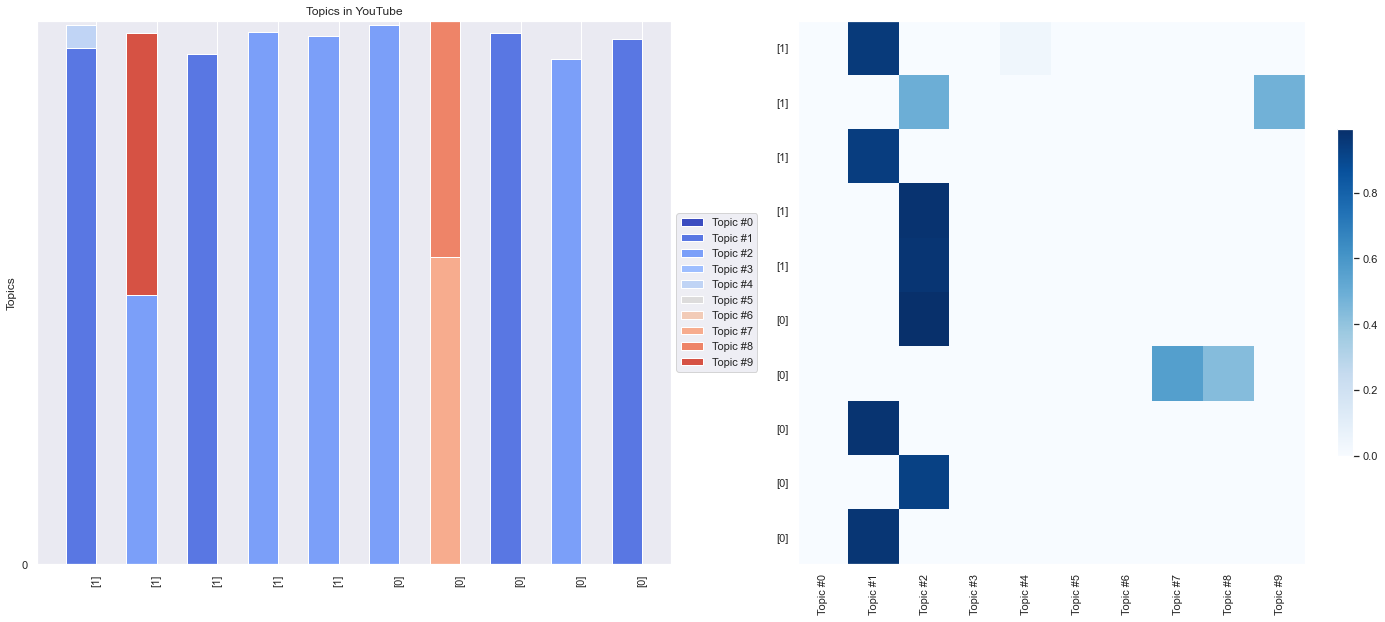

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Visualize as a stacked bar chart
N = 10
ind = np.arange(N)
K = ytb_lda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, color=color)
    else:
        p = ax1.bar(ind, ytb_ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ytb_ldaDFVis[:, k]
    plots.append(p)
    
ax1.set_ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
ax1.set_ylabel('Topics')

ax1.set_title('Topics in ' + "YouTube")
ax1.set_xticks(ind+width/2)
ax1.set_xticklabels(ytb_ldaDFVisNames, rotation='vertical')

ax1.set_yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
ax1.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
ax1.figure.show()

ax2.pcolor(ytb_ldaDFVis, norm=None, cmap='Blues')
ax2.set_yticks(np.arange(ytb_ldaDFVis.shape[0])+0.5)
ax2.set_yticklabels(ytb_ldaDFVisNames);
ax2.set_xticks(np.arange(ytb_ldaDFVis.shape[1])+0.5)
ax2.set_xticklabels(topic_labels, rotation=90);
ax2.invert_yaxis()
fig.colorbar(ax2.pcolormesh(ytb_ldaDFVis, norm=None, cmap='Blues'), ax=ax2, shrink=0.6)

plt.show()

#### NLTK Topic Modeling

In [102]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def make_bigrams(lemmas, min_count=5):
    bigram = models.Phrases(lemmas, min_count)
    bigram_mod = models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in lemmas]

def make_bag_words(lemmas):
    dictionary = corpora.Dictionary([i for i in lemmas])
    bow_corpus = [dictionary.doc2bow(text) for text in lemmas]
    return dictionary, bow_corpus

In [103]:
def nltkTopicModeling(df_list, title_list, num_topics=3, num_words=20):
    for i in range(len(df_list)):
        print("Topic Modeling for " + title_list[i])
        text = df_list[i].text.apply(get_lemmas)
        dic, bow = make_bag_words(make_bigrams(text))
        model = models.ldamodel.LdaModel(bow, num_topics=num_topics, id2word=dic, passes=20, iterations=400)
        print(model.print_topics(num_words=num_words))
        print("\n")

In [104]:
nltkTopicModeling(df_lst, title_lst)

Topic Modeling for Reddit
[(0, '0.019*"armour" + 0.015*"’" + 0.014*"http" + 0.014*"shirt" + 0.012*"shoe" + 0.009*"one" + 0.008*"get" + 0.008*"anyone_know" + 0.007*"like" + 0.006*"find" + 0.005*"look" + 0.005*"make" + 0.005*"\'\'" + 0.005*"``" + 0.005*"\'s" + 0.005*"order" + 0.005*"product" + 0.005*"n\'t" + 0.004*"ua" + 0.004*"time"'), (1, '0.022*"armour" + 0.014*"ua" + 0.011*"’" + 0.009*"shoe" + 0.009*"get" + 0.007*"\'s" + 0.006*"like" + 0.006*"find" + 0.006*"one" + 0.006*"anyone" + 0.006*"would" + 0.005*"code" + 0.005*"store" + 0.005*"look" + 0.005*"know" + 0.005*"go" + 0.005*"product" + 0.005*"http" + 0.004*"thanks" + 0.004*"n\'t"'), (2, '0.019*"ua" + 0.013*"armour" + 0.011*"look" + 0.009*"new" + 0.009*"get" + 0.009*"n\'t" + 0.008*"\'m" + 0.007*"\'s" + 0.006*"like" + 0.006*"help" + 0.006*"wear" + 0.006*"go" + 0.005*"find" + 0.005*"anyone" + 0.005*"try" + 0.005*"thanks" + 0.005*"make" + 0.004*"use" + 0.004*"short" + 0.004*"\'ve"')]


Topic Modeling for Twitter
[(0, '0.057*"underarmour